In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
cuda = torch.cuda.is_available()
cuda =False
device = 'cuda' if cuda else 'cpu'
%matplotlib inline

In [2]:
# Overview of ID class names and class identifiers
class_dict = {  "Abyssinian": 0,
                "american_bulldog": 1,
                "american_pit_bull_terrier": 2,
                "basset_hound": 3,
                "beagle": 4,
                "Bengal": 5,
                "Birman": 6,
                "Bombay": 7,
                "boxer": 8,
                "British_Shorthair": 9,
                "chihuahua": 10,
                "Egyptian_Mau": 11,
                "english_cocker_spaniel": 12,
                "english_setter": 13,
                "german_shorthaired": 14,
                "great_pyrenees": 15,
                "havanese": 16,
                "japanese_chin": 17,
                "keeshond": 18,
                "leonberger": 19,
                "Maine_Coon": 20,
                "miniature_pinscher": 21,
                "newfoundland": 22,
                "Persian": 23,
                "pomeranian": 24,
                "pug": 25,
                "Ragdoll": 26,
                "Russian_Blue": 27,
                "saint_bernard": 28,
                "samoyed": 29,
                "scottish_terrier": 30,
                "shiba_inu": 31,
                "Siamese": 32,
                "Sphynx": 33,
                "staffordshire_bull_terrier": 34,
                "wheaten_terrier": 35,
                "yorkshire_terrier": 36}

In [3]:
# Load in all the trasin and val datasets.
# Import cats and dogs dataset
all_images_path = ".\cats_and_dogs\images"

# Train/val split with 90/10
import glob
from PIL import Image
from torchvision.transforms import ToTensor
import re

batch_size = 32
img_height = 224
img_width = 224

# Define transformations for ID
train_transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop((img_width, img_height)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Define transformations for OOD
all_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

# Custom image dataset to properly load cats and dogs
#  one of the issues was naming the images and assigning them to the correct class in a weird file structure
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        img_paths_bad = glob.glob(os.path.join(root_dir, '*.jpg'))  # Cats and dogs only uses .jpg files

        img_paths = [i.replace("\\", "/") for i in img_paths_bad]

        for img_path in img_paths:
            label = os.path.splitext(os.path.basename(img_path))[0]  # Extract label from filename
            self.image_paths.append(img_path)
            self.labels.append(label)

        labs = [class_dict[re.sub(r'_\d+', '', i)] for i in self.labels]
        self.labels = labs

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # When requesting item from the dataset, this returns the correct image, label combination
        #  This is in line with the required pytorch format of a custom dataset https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


dataset = CustomImageDataset(root_dir="cats_and_dogs/images", transform=all_transform)
n_val = int(0.1 * len(dataset))

# Split the dataset and update the train transformer
train_dataset, val_dataset = random_split(dataset, [len(dataset) - n_val, n_val])
train_dataset.dataset.transform = train_transform

s12_train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
s12_val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)


In [4]:
batch_size = 32
img_height = 224
img_width = 224

# Define transformations for ID
train_transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomResizedCrop((img_width, img_height)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Define transformations for OOD
all_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
])

# Imagefolder for ID3
dataset = ImageFolder(root='celebfaces_id3', transform=all_transform)

# Calculate the number of validation samples = 10%
n_val = int(0.1 * len(dataset))

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [len(dataset) - n_val, n_val])
train_dataset.dataset.transform = train_transform

s3_train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
s3_val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

In [5]:
from tqdm import tqdm
# For a list of network weights:
#  return list of losses, list of training accuracies and list of validation accuracies

def get_loss_accs_res(file_name_list, res_train_loader, res_val_loader, num_classes):
    loss_list = list()
    trainacc_list = list()
    valacc_list = list()

    for file_name in tqdm(file_name_list):
        # Load model. Where we transfer learned resnet18 from Imagenet1k weights to cats and dogs
        from torchvision.models import resnet18, ResNet18_Weights
        
        pretrained_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        # Unlock layers
        for param in pretrained_resnet.parameters():
            param.requires_grad = True
        
        pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_classes)
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(pretrained_resnet.parameters(), lr=0.001, momentum=0.9)
        
        # Load pre-trained weights
        if file_name is not False:
            pretrained_resnet.load_state_dict(torch.load(file_name))
        pretrained_resnet.eval()
        
        pretrained_resnet.train()
    
        correct = 0
        total = 0
        epoch_loss = list()
        for inputs, labels in res_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
        
            outputs = pretrained_resnet(inputs)
            loss = criterion(outputs, labels)
            epoch_loss.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        loss_list.append(sum(epoch_loss)/len(epoch_loss))
        trainacc_list.append(100 * correct / total)
        
        correct = 0
        total = 0
        pretrained_resnet.eval()
        with torch.no_grad():
            for inputs, labels in res_val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = pretrained_resnet(inputs)
                # Update validation metrics if needed
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        valacc_list.append(100 * correct / total)

    return loss_list, trainacc_list, valacc_list


In [6]:
from tqdm import tqdm
# For a list of network weights:
#  return list of losses, list of training accuracies and list of validation accuracies
#  but now for VGG network instead of Resnet

def get_loss_accs_vgg(file_name_list, vgg_train_loader, vgg_val_loader, num_classes):
    loss_list = list()
    trainacc_list = list()
    valacc_list = list()

    for file_name in tqdm(file_name_list):
        # Load model. Where we transfer learned resnet18 from Imagenet1k weights to cats and dogs
        from torchvision.models import vgg16, VGG16_Weights
        
        pretrained_vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        
        # Unlock layers
        for param in pretrained_vgg.parameters():
            param.requires_grad = True

        pretrained_vgg.classifier[-1] = nn.Linear(in_features=vgg12.classifier[-1].in_features, out_features=num_classes)
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(pretrained_vgg.parameters(), lr=0.001, momentum=0.9)
        
        # Load pre-trained weights
        if file_name is not False:
            pretrained_vgg.load_state_dict(torch.load(file_name))
        pretrained_vgg.eval()
        
        pretrained_vgg.train()
    
        correct = 0
        total = 0
        epoch_loss = list()
        for inputs, labels in vgg_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
        
            outputs = pretrained_vgg(inputs)
            loss = criterion(outputs, labels)
            epoch_loss.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        loss_list.append(sum(epoch_loss)/len(epoch_loss))
        trainacc_list.append(100 * correct / total)
        
        correct = 0
        total = 0
        pretrained_vgg.eval()
        with torch.no_grad():
            for inputs, labels in vgg_val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = pretrained_vgg(inputs)
                # Update validation metrics if needed
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        valacc_list.append(100 * correct / total)

    return loss_list, trainacc_list, valacc_list


In [7]:
res_cf_file_list = [False, "celebFaces_resnet_10.pth", "celebFaces_resnet_25.pth", "celebFaces_resnet_50.pth", "celebFaces_resnet_75.pth", "celebFaces_resnet_100.pth", "celebFaces_resnet125.pth", "celebFaces_resnet150.pth", "celebFaces_resnet175.pth", "celebFaces_resnet200.pth"]
vgg_cf_file_list = [False, "celebFaces_vgg_10.pth", "celebFaces_vgg_20.pth", "celebFaces_vgg_30.pth", "celebFaces_vgg_40.pth", "celebFaces_vgg_50.pth", "celebFaces_vgg_60.pth", "celebFaces_vgg_70.pth", "celebFaces_vgg_80.pth", "celebFaces_vgg_90.pth", "celebFaces_vgg_100.pth", "celebFaces_vgg_100.pth", "celebFaces_vgg_110.pth", "celebFaces_vgg_120.pth", "celebFaces_vgg_130.pth", "celebFaces_vgg_140.pth", "celebFaces_vgg_150.pth", "celebFaces_vgg_160.pth", "celebFaces_vgg_170.pth", "celebFaces_vgg_180.pth", "celebFaces_vgg_190.pth", "celebFaces_vgg_200.pth", "celebFaces_vgg_210.pth", "celebFaces_vgg_220.pth", "celebFaces_vgg_230.pth", "celebFaces_vgg_240.pth", "celebFaces_vgg_250.pth"]
res_cd_file_list = ["catsDogs_resnet_0.pth", "catsDogs_resnet_5.pth", "catsDogs_resnet_25.pth", "catsDogs_resnet_50.pth", "catsDogs_resnet_75.pth", "catsDogs_resnet_100.pth"]
vgg_cd_file_list = [False, "catsDogs_vgg_10.pth", "catsDogs_vgg_20.pth", "catsDogs_vgg_25.pth", "catsDogs_vgg_30.pth", "catsDogs_vgg_50.pth", "catsDogs_vgg_60.pth", "catsDogs_vgg_70.pth", "catsDogs_vgg_75.pth", "catsDogs_vgg_80.pth", "catsDogs_vgg_90.pth", "catsDogs_vgg_100.pth"]

# res_cd_loss_list, res_cd_trainacc_list, res_cd_valacc_list = get_loss_accs_res(res_cd_file_list, s12_train_loader, s12_val_loader, 37)
# vgg_cd_loss_list, vgg_cd_trainacc_list, vgg_cd_valacc_list = get_loss_accs_vgg(vgg_cd_file_list, s12_train_loader, s12_val_loader, 37)
# res_cf_loss_list, res_cf_trainacc_list, res_cf_valacc_list = get_loss_accs_res(res_cf_file_list, s3_train_loader, s3_val_loader, 101)
# vgg_cf_loss_list, vgg_cf_trainacc_list, vgg_cf_valacc_list = get_loss_accs_vgg(vgg_cf_file_list, s3_train_loader, s3_val_loader, 101)


In [42]:
# vgg_cd
vgg_cd_loss_list, vgg_cd_trainacc_list, vgg_cd_valacc_list = [3.6906578678351183, 0.6956237374733274, 0.5914176940344847, 0.4968010976265829, 0.520968552499723, 0.5365359707233998], [3.0070666065253344, 77.94316644113667, 81.70199969929334, 84.78424297098181, 83.62652232746956, 83.02510900616448], [2.571041948579161, 82.27334235453316, 83.62652232746956, 87.14479025710419, 85.92692828146143, 87.00947225981055]

# res_cd
res_cd_loss_list, res_cd_trainacc_list, res_cd_valacc_list = [3.797189258612119, 0.7573737556544634, 0.5007136622085594, 0.5048173543495628, 0.5064522442049705, 0.5032107249762003], [2.8567132761990677, 77.53721244925575, 84.93459630130808, 84.90452563524282, 84.91956096827545, 84.84438430311232], [2.300405953991881, 76.99594046008119, 85.38565629228687, 85.79161028416779, 86.06224627875507, 85.92692828146143]

# vgg_cf
vgg_cf_loss_list, vgg_cf_trainacc_list, vgg_cf_valacc_list = [4.683135918208531, 3.0339188235146657, 1.9209246401275908, 1.4350937447909797, 1.1180816016026907, 0.9352052547037601, 0.7401404315938375, 0.8467298086200442, 0.6918586143957717, 0.8728692302746432, 0.5253445662923956, 0.5343042400532535, 0.464971261232027, 0.532545555382967, 0.43853099726441414, 0.4350748998778207, 0.46361390507913064, 0.3683026069109993, 0.3854174341041861, 0.38129345729664366, 0.3259108253779622], [0.9080590238365494, 22.758229284903518, 46.76503972758229, 59.47786606129399, 69.1827468785471, 75.02837684449489, 78.94438138479, 77.69580022701476, 81.55505107832009, 77.41203178206584, 84.7900113507378, 84.84676503972759, 86.88989784335982, 86.77639046538025, 87.96821793416572, 87.6844494892168, 87.11691259931895, 89.67082860385925, 88.98978433598184, 89.1600454029512, 90.69239500567537], [1.0256410256410255, 26.153846153846153, 62.56410256410256, 68.71794871794872, 80.0, 78.97435897435898, 83.07692307692308, 86.15384615384616, 91.7948717948718, 90.25641025641026, 91.28205128205128, 90.76923076923077, 89.74358974358974, 91.28205128205128, 86.15384615384616, 92.82051282051282, 90.76923076923077, 94.35897435897436, 92.3076923076923, 91.7948717948718, 94.35897435897436]

# res_cf
res_cf_loss_list, res_cf_trainacc_list, res_cf_valacc_list = [4.851274234907968, 2.639981116567339, 1.2877666705421038, 0.7180609266672816, 0.5347508902528456, 0.4756952997829233, 0.3670881527609059, 0.37668467446097303, 0.35016088733183487, 0.2910334229735391],  [1.0215664018161181, 45.00567536889898, 72.8717366628831, 84.39273552780931, 88.02497162315551, 89.5005675368899, 92.39500567536889, 91.03291713961407, 91.88422247446084, 93.18955732122588], [1.5384615384615385, 44.1025641025641, 77.94871794871794, 86.15384615384616, 86.15384615384616, 91.7948717948718, 82.56410256410257, 95.8974358974359, 93.84615384615384, 94.87179487179488]

# res_new_cf
new_res_cf_loss_list, new_res_cf_trainacc_list, new_res_cf_valacc_list = [4.056671214955194, 3.507070247616087, 3.0779634969575063, 2.693118150745119, 2.3415125778743198, 2.021891877055168, 1.7459096908569336, 1.493127927184105, 1.338390095957688, 1.214823166174548, 1.0822434585009302, 1.0305198532130038, 0.9534925451236111, 0.8543157103870597, 0.8033901639282703, 0.7810998146555254, 0.6972074402230126, 0.6691875824970859, 0.6955108631934438, 0.580378871144993, 0.5460370233548539, 0.5436866709164211, 0.5250453130741205, 0.486769504312958, 0.6091144952390876, 0.4652403946965933, 0.4926755621231028, 0.44832887606961386, 0.40074392168649603, 0.42398174945265055, 0.4162817379193647, 0.47522876311891843, 0.3815274007086243, 0.4030754065274128, 0.44083503474082264, 0.38335548394492697, 0.4008420413093908, 0.4180222490270223, 0.4036305638562356, 0.32116794320089476, 0.38830669902797255, 0.30664920221482006, 0.352069895880829, 0.33146776052724036, 0.3436521768037762, 0.37388902895950843, 0.2971523062192968, 0.3235066916926631, 0.2870425426600767, 0.3427285689062306, 0.3431327320701842, 0.3650640811372016], [8.059023836549375, 15.72077185017026, 22.92849035187287, 31.725312145289443, 40.12485811577753, 50.05675368898979, 55.10783200908059, 62.82633371169126, 65.60726447219069, 68.78547105561861, 75.93643586833144, 76.39046538024972, 77.07150964812713, 79.39841089670828, 79.45516458569807, 82.12258796821793, 83.08740068104427, 83.20090805902383, 84.84676503972759, 85.30079455164585, 86.15209988649262, 85.47105561861521, 86.83314415437003, 88.19523269012485, 86.03859250851305, 88.25198637911464, 88.13847900113507, 88.64926220204313, 89.61407491486946, 89.78433598183882, 90.46538024971623, 89.44381384790012, 90.29511918274687, 90.46538024971623, 88.81952326901249, 89.89784335981838, 89.67082860385925, 90.01135073779795, 89.67082860385925, 91.71396140749148, 91.03291713961407, 93.01929625425653, 91.54370034052214, 90.91940976163451, 91.71396140749148, 91.54370034052214, 92.50851305334847, 92.16799091940976, 92.90578887627696, 92.33825198637912, 91.03291713961407, 91.54370034052214], [7.6923076923076925, 21.53846153846154, 30.76923076923077, 37.94871794871795, 44.1025641025641, 53.84615384615385, 58.46153846153846, 76.41025641025641, 70.76923076923077, 75.38461538461539, 87.17948717948718, 81.53846153846153, 83.07692307692308, 81.53846153846153, 86.15384615384616, 86.66666666666667, 86.66666666666667, 87.6923076923077, 87.6923076923077, 85.12820512820512, 89.74358974358974, 90.76923076923077, 85.64102564102564, 89.23076923076923, 90.25641025641026, 87.6923076923077, 89.74358974358974, 88.71794871794872, 90.76923076923077, 94.35897435897436, 91.28205128205128, 89.74358974358974, 91.7948717948718, 90.25641025641026, 93.33333333333333, 92.82051282051282, 93.84615384615384, 90.76923076923077, 91.7948717948718, 92.82051282051282, 92.3076923076923, 93.84615384615384, 94.87179487179488, 95.8974358974359, 93.84615384615384, 94.87179487179488, 93.33333333333333, 94.87179487179488, 95.38461538461539, 91.7948717948718, 93.84615384615384, 91.7948717948718]


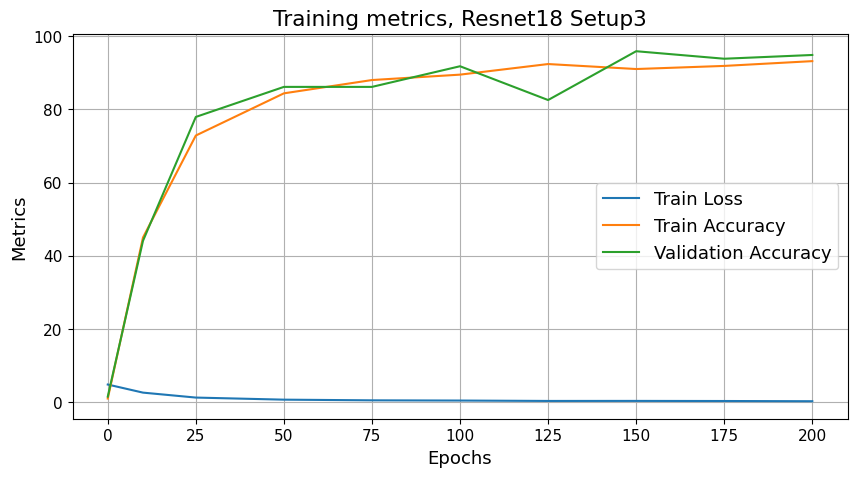

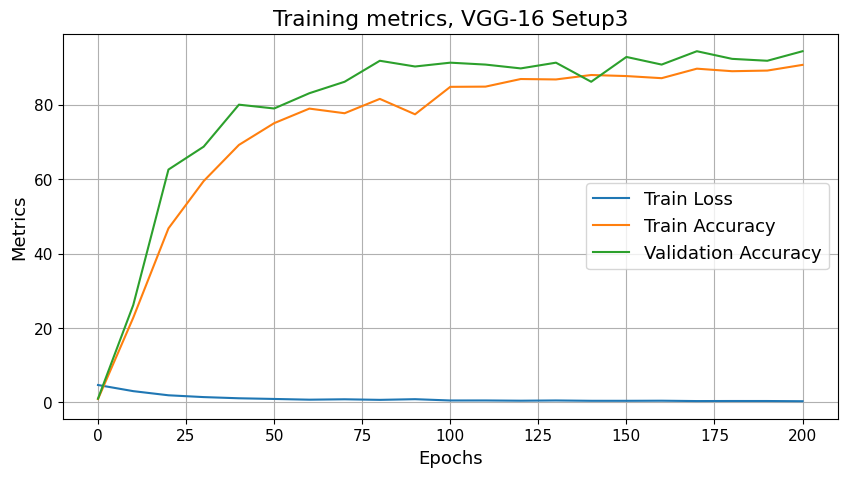

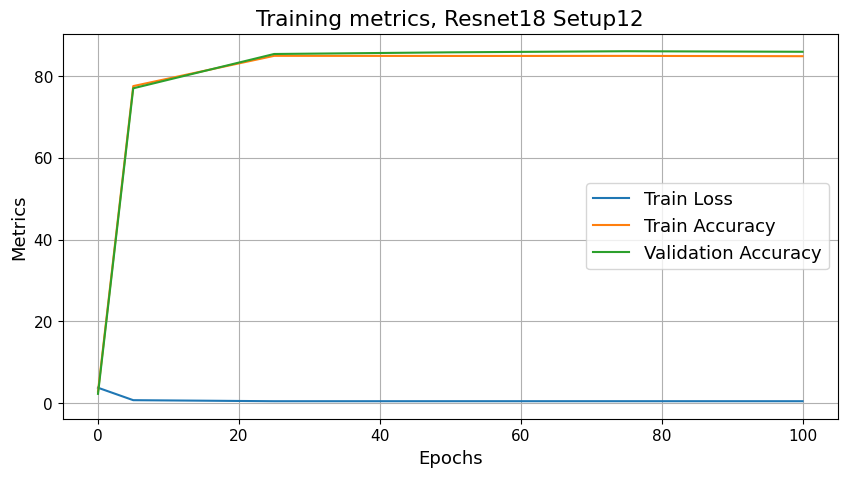

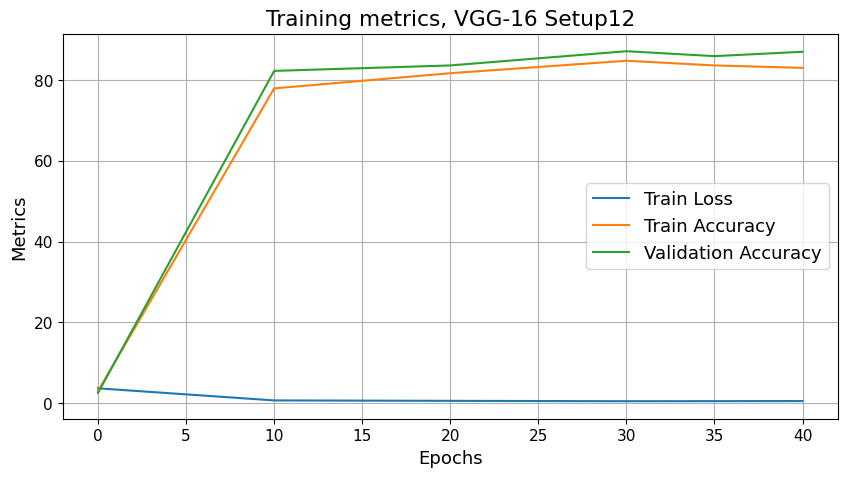

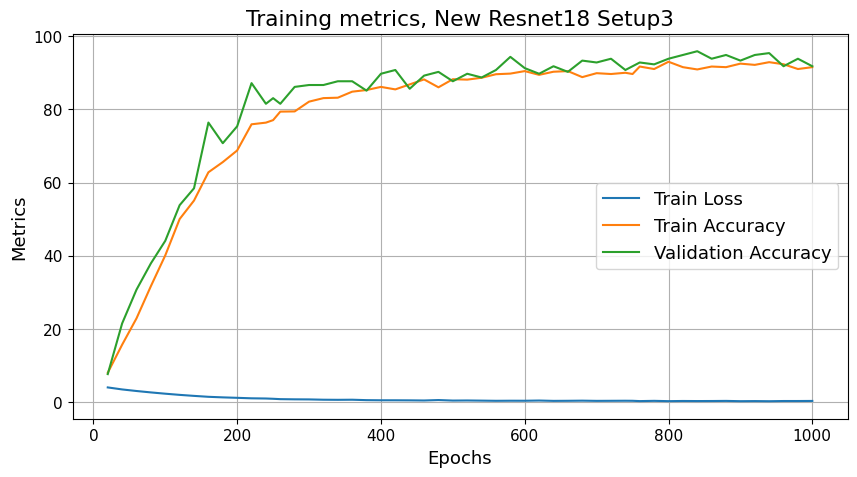

In [43]:
res_cf_epochs = [0, 10, 25, 50, 75, 100, 125, 150, 175, 200]
vgg_cf_epochs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
res_cd_epochs = [0, 5, 25, 50, 75, 100]
vgg_cd_epochs = [0, 10, 20, 30, 35, 40]
res_new_cf_epochs = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 250, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 750, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000]

def vis_loss_acc(epochs_list, loss_list, trainacc_list, valacc_list, title):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_list, loss_list, label='Train Loss')
    plt.plot(epochs_list, trainacc_list, label='Train Accuracy')
    plt.plot(epochs_list, valacc_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

vis_loss_acc(res_cf_epochs, res_cf_loss_list, res_cf_trainacc_list, res_cf_valacc_list, "Training metrics, Resnet18 Setup3")
vis_loss_acc(vgg_cf_epochs, vgg_cf_loss_list, vgg_cf_trainacc_list, vgg_cf_valacc_list, "Training metrics, VGG-16 Setup3")
vis_loss_acc(res_cd_epochs, res_cd_loss_list, res_cd_trainacc_list, res_cd_valacc_list, "Training metrics, Resnet18 Setup12")
vis_loss_acc(vgg_cd_epochs, vgg_cd_loss_list, vgg_cd_trainacc_list, vgg_cd_valacc_list, "Training metrics, VGG-16 Setup12")
vis_loss_acc(res_new_cf_epochs, new_res_cf_loss_list, new_res_cf_trainacc_list, new_res_cf_valacc_list, "Training metrics, New Resnet18 Setup3")


In [10]:
from torchvision.models import vgg16, resnet18

# We choose the following files:
# Resnet3: 150 epochs | "celebFaces_resnet150.pth"
# VGG3: 160 epochs | "celebFaces_vgg_160.pth"
# Resnet12: 25 epochs | "catsDogs_resnet_25.pth"
# VGG12: 20 epochs | "catsDogs_vgg_20.pth"

# Load models. Start with resnet
resnet3 = resnet18()
resnet12 = resnet18()

for param in resnet3.parameters():
    param.requires_grad = True

for param in resnet12.parameters():
    param.requires_grad = True

resnet3.fc = nn.Linear(resnet3.fc.in_features, 101)
resnet12.fc = nn.Linear(resnet12.fc.in_features, 37)
criterion = nn.CrossEntropyLoss()
optimizerresnet3 = torch.optim.SGD(resnet3.parameters(), lr=0.001, momentum=0.9)
optimizerresnet12 = torch.optim.SGD(resnet12.parameters(), lr=0.001, momentum=0.9)

resnet3.load_state_dict(torch.load('celebFaces_resnet150.pth', map_location=torch.device('cpu')))
resnet12.load_state_dict(torch.load('catsDogs_resnet_25.pth', map_location=torch.device('cpu')))
resnet3.eval()
resnet12.eval()

# Load VGG
vgg3 = vgg16()
vgg12 = vgg16()

for param in vgg3.parameters():
    param.requires_grad = True

for param in vgg12.parameters():
    param.requires_grad = True

# Set the last layer size
vgg3.classifier[-1] = nn.Linear(in_features=vgg3.classifier[-1].in_features, out_features=101)
vgg12.classifier[-1] = nn.Linear(in_features=vgg12.classifier[-1].in_features,out_features=37)
optimizervgg3 = torch.optim.SGD(vgg3.parameters(), lr=0.001, momentum=0.9)
optimizervgg12 = torch.optim.SGD(vgg12.parameters(), lr=0.001, momentum=0.9)

vgg3.load_state_dict(torch.load('celebFaces_vgg_160.pth', map_location=torch.device('cpu')))
vgg12.load_state_dict(torch.load('catsDogs_vgg_20.pth', map_location=torch.device('cpu')))
vgg3.eval()
vgg12.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
# Playbook now that we have the model-epoch combinations:
# 1. Load in OOD datasets
# 2. Load in the OOD methods and visualization code
# 3. Perform OOD detection on VGG and Resnet for setups 1,2,3

In [12]:
# 1. Load in OOD datasets
from torch.utils.data import Subset
from PIL import Image
import glob

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
s1ood_dataset = ImageFolder(root='imagenet_val', transform=preprocess)
s1OOD_Dataloader = DataLoader(s1ood_dataset, batch_size=32, shuffle=True)
s2ood_dataset = ImageFolder(root='ood23', transform=preprocess)
s2OOD_Dataloader = DataLoader(s2ood_dataset, batch_size=32, shuffle=True)
s3ood_dataset = ImageFolder(root='ood3', transform=preprocess)
s3OOD_Dataloader = DataLoader(s3ood_dataset, batch_size=32, shuffle=True)

In [13]:
# 2. Load in the OOD methods and visualization code
# These methods were taken from different sources. 
# Odin, MSP and Energy I got from here https://github.com/deeplearning-wisc/large_scale_ood/blob/master/test_baselines.py
# DDU from https://github.com/omegafragger/DDU/blob/main/utils/gmm_utils.py which required a lot of adapting
# Mahalanobis I created myself

def iterate_data_odin(data_loader, model, epsilon=0.0014, temper=1000):
    criterion = torch.nn.CrossEntropyLoss()
    confs = []
    loader_y = []
    for b, (x, y) in enumerate(data_loader):
        # loader_y.append(y)
        x = Variable(x, requires_grad=True)
        outputs = model(x)

        maxIndexTemp = np.argmax(outputs.data.cpu().numpy(), axis=1)
        outputs = outputs / temper

        labels = Variable(torch.LongTensor(maxIndexTemp))
        loss = criterion(outputs, labels)
        loss.backward()

        # Normalizing the gradient to binary in {0, 1}
        gradient = torch.ge(x.grad.data, 0)
        gradient = (gradient.float() - 0.5) * 2

        # Adding small perturbations to images
        tempInputs = torch.add(x.data, gradient, alpha=-epsilon)
        outputs = model(Variable(tempInputs))
        outputs = outputs / temper
        # Calculating the confidence after adding perturbations
        nnOutputs = outputs.data.cpu()
        nnOutputs = nnOutputs.numpy()
        nnOutputs = nnOutputs - np.max(nnOutputs, axis=1, keepdims=True)
        nnOutputs = np.exp(nnOutputs) / np.sum(np.exp(nnOutputs), axis=1, keepdims=True)

        confs.extend(np.max(nnOutputs, axis=1))

    return np.array(confs), loader_y

# s12_res_odin_in_scores, _ = iterate_data_odin(s12_train_loader, resnet12)
# s3_res_odin_in_scores, _ = iterate_data_odin(s3_train_loader, resnet3)
# s1_res_odin_out_scores, _ = iterate_data_odin(s1OOD_Dataloader, resnet12)
# s2_res_odin_out_scores, _ = iterate_data_odin(s2OOD_Dataloader, resnet12)
# s3_res_odin_out_scores, _ = iterate_data_odin(s3OOD_Dataloader, resnet3)
# s12_vgg_odin_in_scores, _ = iterate_data_odin(s12_train_loader, vgg12)
# s3_vgg_odin_in_scores, _ = iterate_data_odin(s3_train_loader, vgg3)
# s1_vgg_odin_out_scores, _ = iterate_data_odin(s1OOD_Dataloader, vgg12)
# s2_vgg_odin_out_scores, _ = iterate_data_odin(s2OOD_Dataloader, vgg12)
# s3_vgg_odin_out_scores, _ = iterate_data_odin(s3OOD_Dataloader, vgg3)

# odin_s12_res_in_examples = s12_res_odin_in_scores.reshape((-1, 1))
# odin_s3_res_in_examples = s3_res_odin_in_scores.reshape((-1, 1))
# odin_s1_res_out_examples = s1_res_odin_out_scores.reshape((-1, 1))
# odin_s2_res_out_examples = s2_res_odin_out_scores.reshape((-1, 1))
# odin_s3_res_out_examples = s3_res_odin_out_scores.reshape((-1, 1))
# odin_s12_vgg_in_examples = s12_vgg_odin_in_scores.reshape((-1, 1))
# odin_s3_vgg_in_examples = s3_vgg_odin_in_scores.reshape((-1, 1))
# odin_s1_vgg_out_examples = s1_vgg_odin_out_scores.reshape((-1, 1))
# odin_s2_vgg_out_examples = s2_vgg_odin_out_scores.reshape((-1, 1))
# odin_s3_vgg_out_examples = s3_vgg_odin_out_scores.reshape((-1, 1))

# np.save('exp2saves/odin_s12_res_in_examples.npy', odin_s12_res_in_examples)
# np.save('exp2saves/odin_s3_res_in_examples.npy', odin_s3_res_in_examples)
# np.save('exp2saves/odin_s1_res_out_examples.npy', odin_s1_res_out_examples)
# np.save('exp2saves/odin_s2_res_out_examples.npy', odin_s2_res_out_examples)
# np.save('exp2saves/odin_s3_res_out_examples.npy', odin_s3_res_out_examples)
# np.save('exp2saves/odin_s12_vgg_in_examples.npy', odin_s12_vgg_in_examples)
# np.save('exp2saves/odin_s3_vgg_in_examples.npy', odin_s3_vgg_in_examples)
# np.save('exp2saves/odin_s1_vgg_out_examples.npy', odin_s1_vgg_out_examples)
# np.save('exp2saves/odin_s2_vgg_out_examples.npy', odin_s2_vgg_out_examples)
# np.save('exp2saves/odin_s3_vgg_out_examples.npy', odin_s3_vgg_out_examples)

odin_s12_res_in_examples = np.load('exp2saves/odin_s12_res_in_examples.npy')
odin_s3_res_in_examples = np.load('exp2saves/odin_s3_res_in_examples.npy')
odin_s1_res_out_examples = np.load('exp2saves/odin_s1_res_out_examples.npy')
odin_s2_res_out_examples = np.load('exp2saves/odin_s2_res_out_examples.npy')
odin_s3_res_out_examples = np.load('exp2saves/odin_s3_res_out_examples.npy')
odin_s12_vgg_in_examples = np.load('exp2saves/odin_s12_vgg_in_examples.npy')
odin_s3_vgg_in_examples = np.load('exp2saves/odin_s3_vgg_in_examples.npy')
odin_s1_vgg_out_examples = np.load('exp2saves/odin_s1_vgg_out_examples.npy')
odin_s2_vgg_out_examples = np.load('exp2saves/odin_s2_vgg_out_examples.npy')
odin_s3_vgg_out_examples = np.load('exp2saves/odin_s3_vgg_out_examples.npy')

In [14]:
def iterate_data_energy(data_loader, model, temper=1):
    confs = []
    loader_y = []
    for b, (x, y) in enumerate(data_loader):
        # loader_y.append(y)
        with torch.no_grad():
            x = x
            # compute output, measure accuracy and record loss.
            logits = model(x)

            conf = temper * torch.logsumexp(logits / temper, dim=1)
            confs.extend(conf.data.cpu().numpy())
    return np.array(confs), loader_y

# s12_res_energy_in_scores, _ = iterate_data_energy(s12_train_loader, resnet12)
# s3_res_energy_in_scores, _ = iterate_data_energy(s3_train_loader, resnet3)
# s1_res_energy_out_scores, _ = iterate_data_energy(s1OOD_Dataloader, resnet12)
# s2_res_energy_out_scores, _ = iterate_data_energy(s2OOD_Dataloader, resnet12)
# s3_res_energy_out_scores, _ = iterate_data_energy(s3OOD_Dataloader, resnet3)
# s12_vgg_energy_in_scores, _ = iterate_data_energy(s12_train_loader, vgg12)
# s3_vgg_energy_in_scores, _ = iterate_data_energy(s3_train_loader, vgg3)
# s1_vgg_energy_out_scores, _ = iterate_data_energy(s1OOD_Dataloader, vgg12)
# s2_vgg_energy_out_scores, _ = iterate_data_energy(s2OOD_Dataloader, vgg12)
# s3_vgg_energy_out_scores, _ = iterate_data_energy(s3OOD_Dataloader, vgg3)

# energy_s12_res_in_examples = s12_res_energy_in_scores.reshape((-1, 1))
# energy_s3_res_in_examples = s3_res_energy_in_scores.reshape((-1, 1))
# energy_s1_res_out_examples = s1_res_energy_out_scores.reshape((-1, 1))
# energy_s2_res_out_examples = s2_res_energy_out_scores.reshape((-1, 1))
# energy_s3_res_out_examples = s3_res_energy_out_scores.reshape((-1, 1))
# energy_s12_vgg_in_examples = s12_vgg_energy_in_scores.reshape((-1, 1))
# energy_s3_vgg_in_examples = s3_vgg_energy_in_scores.reshape((-1, 1))
# energy_s1_vgg_out_examples = s1_vgg_energy_out_scores.reshape((-1, 1))
# energy_s2_vgg_out_examples = s2_vgg_energy_out_scores.reshape((-1, 1))
# energy_s3_vgg_out_examples = s3_vgg_energy_out_scores.reshape((-1, 1))

# np.save('exp2saves/energy_s12_res_in_examples.npy', energy_s12_res_in_examples)
# np.save('exp2saves/energy_s3_res_in_examples.npy', energy_s3_res_in_examples)
# np.save('exp2saves/energy_s1_res_out_examples.npy', energy_s1_res_out_examples)
# np.save('exp2saves/energy_s2_res_out_examples.npy', energy_s2_res_out_examples)
# np.save('exp2saves/energy_s3_res_out_examples.npy', energy_s3_res_out_examples)
# np.save('exp2saves/energy_s12_vgg_in_examples.npy', energy_s12_vgg_in_examples)
# np.save('exp2saves/energy_s3_vgg_in_examples.npy', energy_s3_vgg_in_examples)
# np.save('exp2saves/energy_s1_vgg_out_examples.npy', energy_s1_vgg_out_examples)
# np.save('exp2saves/energy_s2_vgg_out_examples.npy', energy_s2_vgg_out_examples)
# np.save('exp2saves/energy_s3_vgg_out_examples.npy', energy_s3_vgg_out_examples)

energy_s12_res_in_examples = np.load('exp2saves/energy_s12_res_in_examples.npy')
energy_s3_res_in_examples = np.load('exp2saves/energy_s3_res_in_examples.npy')
energy_s1_res_out_examples = np.load('exp2saves/energy_s1_res_out_examples.npy')
energy_s2_res_out_examples = np.load('exp2saves/energy_s2_res_out_examples.npy')
energy_s3_res_out_examples = np.load('exp2saves/energy_s3_res_out_examples.npy')
energy_s12_vgg_in_examples = np.load('exp2saves/energy_s12_vgg_in_examples.npy')
energy_s3_vgg_in_examples = np.load('exp2saves/energy_s3_vgg_in_examples.npy')
energy_s1_vgg_out_examples = np.load('exp2saves/energy_s1_vgg_out_examples.npy')
energy_s2_vgg_out_examples = np.load('exp2saves/energy_s2_vgg_out_examples.npy')
energy_s3_vgg_out_examples = np.load('exp2saves/energy_s3_vgg_out_examples.npy')

In [15]:
def iterate_data_msp(data_loader, model):
    confs = []
    m = torch.nn.Softmax(dim=-1).cuda()
    loader_y = []
    for b, (x, y) in enumerate(data_loader):
        # loader_y.append(y)
        with torch.no_grad():
            x = x
            # compute output, measure accuracy and record loss.
            logits = model(x)

            conf, _ = torch.max(m(logits), dim=-1)
            confs.extend(conf.data.cpu().numpy())
    return np.array(confs), loader_y

# s12_res_msp_in_scores, _ = iterate_data_msp(s12_train_loader, resnet12)
# s3_res_msp_in_scores, _ = iterate_data_msp(s3_train_loader, resnet3)
# s1_res_msp_out_scores, _ = iterate_data_msp(s1OOD_Dataloader, resnet12)
# s2_res_msp_out_scores, _ = iterate_data_msp(s2OOD_Dataloader, resnet12)
# s3_res_msp_out_scores, _ = iterate_data_msp(s3OOD_Dataloader, resnet3)
# s12_vgg_msp_in_scores, _ = iterate_data_msp(s12_train_loader, vgg12)
# s3_vgg_msp_in_scores, _ = iterate_data_msp(s3_train_loader, vgg3)
# s1_vgg_msp_out_scores, _ = iterate_data_msp(s1OOD_Dataloader, vgg12)
# s2_vgg_msp_out_scores, _ = iterate_data_msp(s2OOD_Dataloader, vgg12)
# s3_vgg_msp_out_scores, _ = iterate_data_msp(s3OOD_Dataloader, vgg3)

# msp_s12_res_in_examples = s12_res_msp_in_scores.reshape((-1, 1))
# msp_s3_res_in_examples = s3_res_msp_in_scores.reshape((-1, 1))
# msp_s1_res_out_examples = s1_res_msp_out_scores.reshape((-1, 1))
# msp_s2_res_out_examples = s2_res_msp_out_scores.reshape((-1, 1))
# msp_s3_res_out_examples = s3_res_msp_out_scores.reshape((-1, 1))
# msp_s12_vgg_in_examples = s12_vgg_msp_in_scores.reshape((-1, 1))
# msp_s3_vgg_in_examples = s3_vgg_msp_in_scores.reshape((-1, 1))
# msp_s1_vgg_out_examples = s1_vgg_msp_out_scores.reshape((-1, 1))
# msp_s2_vgg_out_examples = s2_vgg_msp_out_scores.reshape((-1, 1))
# msp_s3_vgg_out_examples = s3_vgg_msp_out_scores.reshape((-1, 1))

# np.save('exp2saves/msp_s12_res_in_examples.npy', msp_s12_res_in_examples)
# np.save('exp2saves/msp_s3_res_in_examples.npy', msp_s3_res_in_examples)
# np.save('exp2saves/msp_s1_res_out_examples.npy', msp_s1_res_out_examples)
# np.save('exp2saves/msp_s2_res_out_examples.npy', msp_s2_res_out_examples)
# np.save('exp2saves/msp_s3_res_out_examples.npy', msp_s3_res_out_examples)
# np.save('exp2saves/msp_s12_vgg_in_examples.npy', msp_s12_vgg_in_examples)
# np.save('exp2saves/msp_s3_vgg_in_examples.npy', msp_s3_vgg_in_examples)
# np.save('exp2saves/msp_s1_vgg_out_examples.npy', msp_s1_vgg_out_examples)
# np.save('exp2saves/msp_s2_vgg_out_examples.npy', msp_s2_vgg_out_examples)
# np.save('exp2saves/msp_s3_vgg_out_examples.npy', msp_s3_vgg_out_examples)

msp_s12_res_in_examples = np.load('exp2saves/msp_s12_res_in_examples.npy')
msp_s3_res_in_examples = np.load('exp2saves/msp_s3_res_in_examples.npy')
msp_s1_res_out_examples = np.load('exp2saves/msp_s1_res_out_examples.npy')
msp_s2_res_out_examples = np.load('exp2saves/msp_s2_res_out_examples.npy')
msp_s3_res_out_examples = np.load('exp2saves/msp_s3_res_out_examples.npy')
msp_s12_vgg_in_examples = np.load('exp2saves/msp_s12_vgg_in_examples.npy')
msp_s3_vgg_in_examples = np.load('exp2saves/msp_s3_vgg_in_examples.npy')
msp_s1_vgg_out_examples = np.load('exp2saves/msp_s1_vgg_out_examples.npy')
msp_s2_vgg_out_examples = np.load('exp2saves/msp_s2_vgg_out_examples.npy')
msp_s3_vgg_out_examples = np.load('exp2saves/msp_s3_vgg_out_examples.npy')

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def get_logits_labels(model, data_loader, device):
    """
    Utility function to get logits and labels.
    """
    model.eval()
    logits = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            label = label.to(device)

            logit = model(data)
            logits.append(logit)
            labels.append(label)
    logits = torch.cat(logits, dim=0)
    labels = torch.cat(labels, dim=0)
    return logits, labels

def test_classification_net(model, data_loader, device):
    """
    This function reports classification accuracy and confusion matrix over a dataset.
    """
    logits, labels = get_logits_labels(model, data_loader, device)
    softmax_prob = F.softmax(logits, dim=1)

    """
    This function reports classification accuracy and confusion matrix given softmax vectors and
    labels from a model.
    """
    labels_list = []
    predictions_list = []
    confidence_vals_list = []

    confidence_vals, predictions = torch.max(softmax_prob, dim=1)
    labels_list.extend(labels.cpu().numpy())
    predictions_list.extend(predictions.cpu().numpy())
    confidence_vals_list.extend(confidence_vals.cpu().numpy())
    accuracy = accuracy_score(labels_list, predictions_list)
    return (
        confusion_matrix(labels_list, predictions_list),
        accuracy,
        labels_list,
        predictions_list,
        confidence_vals_list,
    )

In [17]:
from calibration_metrics import expected_calibration_error
from temperature_scaling import ModelWithTemperature
from gmm_utils import get_embeddings, gmm_fit, gmm_evaluate
from ood_metrics import get_roc_auc, get_roc_auc_logits
from uncertainty_confidence import entropy, logsumexp
import math


def iterate_data_ddu(train_loader, val_loader, out_loader, model):
    # Evaluating the models
    accuracies = []
    
    # Pre temperature scaling
    # m1 - Uncertainty/Confidence Metric 1
    #      for deterministic model: logsumexp, for ensemble: entropy
    # m2 - Uncertainty/Confidence Metric 2
    #      for deterministic model: entropy, for ensemble: MI
    eces = []
    m1_aurocs = []
    m1_auprcs = []
    m2_aurocs = []
    m2_auprcs = []
    
    # Post temperature scaling
    t_eces = []
    t_m1_aurocs = []
    t_m1_auprcs = []
    t_m2_aurocs = []
    t_m2_auprcs = []
    
    for i in range(1):
        print(f"Evaluating run: {(i+1)}")
        device = "cpu"
        model_type = "gmm"
    
        # Evaluating the model(s)
        (conf_matrix, accuracy, labels_list, predictions, confidences,) = test_classification_net(
            model, train_loader, device)
        ece = expected_calibration_error(confidences, predictions, labels_list, num_bins=15)
    
        temp_scaled_net = ModelWithTemperature(model)
        temp_scaled_net.set_temperature(train_loader)
        topt = temp_scaled_net.temperature
    
        (t_conf_matrix, t_accuracy, t_labels_list, t_predictions, t_confidences,) = test_classification_net(
            temp_scaled_net, train_loader, device)
        t_ece = expected_calibration_error(t_confidences, t_predictions, t_labels_list, num_bins=15)
    
        if (model_type == "gmm"):
            # Evaluate a GMM model
            print("GMM Model")
            embeddings, labels = get_embeddings(model, train_loader, num_dim=37, dtype=torch.double,
                                                device=device, storage_device=device,)
    
            try:
                gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)
                logits, labels = gmm_evaluate(model, gaussians_model, train_loader, device=device, 
                                              num_classes=num_classes, storage_device=device,)
    
                val_logits, val_labels = gmm_evaluate(model, gaussians_model, val_loader, device=device, 
                                                      num_classes=num_classes, storage_device=device,)
    
                ood_logits, ood_labels = gmm_evaluate(model, gaussians_model, out_loader, device=device, 
                                                      num_classes=num_classes, storage_device=device,)
    
                (m1_fpr, m1_tpr, m1_thresholds), (m1_precision, m1_recall, m1_prc_thresholds), m1_auroc, m1_auprc = get_roc_auc_logits(logits, ood_logits, logsumexp, device, confidence=True)
                (m2_fpr, m2_tpr, m2_thresholds), (m2_precision, m2_recall, m2_prc_thresholds), m2_auroc, m2_auprc = get_roc_auc_logits(logits, ood_logits, entropy, device)
    
                t_m1_auroc = m1_auroc
                t_m1_auprc = m1_auprc
                t_m2_auroc = m2_auroc
                t_m2_auprc = m2_auprc
    
            except RuntimeError as e:
                print("Runtime Error caught: " + str(e))
                continue
    
        else:
            # Evaluate a normal Softmax model
            print("Softmax Model")
            (_, _, _), (_, _, _), m1_auroc, m1_auprc = get_roc_auc(model, train_loader, out_loader, logsumexp, 
                                                                   device, confidence=True)
            (_, _, _), (_, _, _), m2_auroc, m2_auprc = get_roc_auc(model, train_loader, out_loader, entropy, device)
    
            (_, _, _), (_, _, _), t_m1_auroc, t_m1_auprc = get_roc_auc(temp_scaled_net, train_loader, out_loader, 
                                                                       logsumexp, device, confidence=True,)
            (_, _, _), (_, _, _), t_m2_auroc, t_m2_auprc = get_roc_auc(temp_scaled_net, train_loader, out_loader, 
                                                                       entropy, device)
    
        accuracies.append(accuracy)
    
        # Pre-temperature results
        eces.append(ece)
        m1_aurocs.append(m1_auroc)
        m1_auprcs.append(m1_auprc)
        m2_aurocs.append(m2_auroc)
        m2_auprcs.append(m2_auprc)
    
        # Post-temperature results
        t_eces.append(t_ece)
        t_m1_aurocs.append(t_m1_auroc)
        t_m1_auprcs.append(t_m1_auprc)
        t_m2_aurocs.append(t_m2_auroc)
        t_m2_auprcs.append(t_m2_auprc)
    
    accuracy_tensor = torch.tensor(accuracies)
    ece_tensor = torch.tensor(eces)
    m1_auroc_tensor = torch.tensor(m1_aurocs)
    m1_auprc_tensor = torch.tensor(m1_auprcs)
    m2_auroc_tensor = torch.tensor(m2_aurocs)
    m2_auprc_tensor = torch.tensor(m2_auprcs)
    
    t_ece_tensor = torch.tensor(t_eces)
    t_m1_auroc_tensor = torch.tensor(t_m1_aurocs)
    t_m1_auprc_tensor = torch.tensor(t_m1_auprcs)
    t_m2_auroc_tensor = torch.tensor(t_m2_aurocs)
    t_m2_auprc_tensor = torch.tensor(t_m2_auprcs)
    
    mean_accuracy = torch.mean(accuracy_tensor)
    mean_ece = torch.mean(ece_tensor)
    mean_m1_auroc = torch.mean(m1_auroc_tensor)
    mean_m1_auprc = torch.mean(m1_auprc_tensor)
    mean_m2_auroc = torch.mean(m2_auroc_tensor)
    mean_m2_auprc = torch.mean(m2_auprc_tensor)
    
    mean_t_ece = torch.mean(t_ece_tensor)
    mean_t_m1_auroc = torch.mean(t_m1_auroc_tensor)
    mean_t_m1_auprc = torch.mean(t_m1_auprc_tensor)
    mean_t_m2_auroc = torch.mean(t_m2_auroc_tensor)
    mean_t_m2_auprc = torch.mean(t_m2_auprc_tensor)
    
    std_accuracy = torch.std(accuracy_tensor) / math.sqrt(accuracy_tensor.shape[0])
    std_ece = torch.std(ece_tensor) / math.sqrt(ece_tensor.shape[0])
    std_m1_auroc = torch.std(m1_auroc_tensor) / math.sqrt(m1_auroc_tensor.shape[0])
    std_m1_auprc = torch.std(m1_auprc_tensor) / math.sqrt(m1_auprc_tensor.shape[0])
    std_m2_auroc = torch.std(m2_auroc_tensor) / math.sqrt(m2_auroc_tensor.shape[0])
    std_m2_auprc = torch.std(m2_auprc_tensor) / math.sqrt(m2_auprc_tensor.shape[0])
    
    std_t_ece = torch.std(t_ece_tensor) / math.sqrt(t_ece_tensor.shape[0])
    std_t_m1_auroc = torch.std(t_m1_auroc_tensor) / math.sqrt(t_m1_auroc_tensor.shape[0])
    std_t_m1_auprc = torch.std(t_m1_auprc_tensor) / math.sqrt(t_m1_auprc_tensor.shape[0])
    std_t_m2_auroc = torch.std(t_m2_auroc_tensor) / math.sqrt(t_m2_auroc_tensor.shape[0])
    std_t_m2_auprc = torch.std(t_m2_auprc_tensor) / math.sqrt(t_m2_auprc_tensor.shape[0])
    
    res_dict = {}
    res_dict["mean"] = {}
    res_dict["mean"]["accuracy"] = mean_accuracy.item()
    res_dict["mean"]["ece"] = mean_ece.item()
    res_dict["mean"]["m1_auroc"] = mean_m1_auroc.item()
    res_dict["mean"]["m1_auprc"] = mean_m1_auprc.item()
    res_dict["mean"]["m2_auroc"] = mean_m2_auroc.item()
    res_dict["mean"]["m2_auprc"] = mean_m2_auprc.item()
    res_dict["mean"]["t_ece"] = mean_t_ece.item()
    res_dict["mean"]["t_m1_auroc"] = mean_t_m1_auroc.item()
    res_dict["mean"]["t_m1_auprc"] = mean_t_m1_auprc.item()
    res_dict["mean"]["t_m2_auroc"] = mean_t_m2_auroc.item()
    res_dict["mean"]["t_m2_auprc"] = mean_t_m2_auprc.item()
    
    res_dict["std"] = {}
    res_dict["std"]["accuracy"] = std_accuracy.item()
    res_dict["std"]["ece"] = std_ece.item()
    res_dict["std"]["m1_auroc"] = std_m1_auroc.item()
    res_dict["std"]["m1_auprc"] = std_m1_auprc.item()
    res_dict["std"]["m2_auroc"] = std_m2_auroc.item()
    res_dict["std"]["m2_auprc"] = std_m2_auprc.item()
    res_dict["std"]["t_ece"] = std_t_ece.item()
    res_dict["std"]["t_m1_auroc"] = std_t_m1_auroc.item()
    res_dict["std"]["t_m1_auprc"] = std_t_m1_auprc.item()
    res_dict["std"]["t_m2_auroc"] = std_t_m2_auroc.item()
    res_dict["std"]["t_m2_auprc"] = std_t_m2_auprc.item()
    
    res_dict["mean"] = {}
    res_dict["mean"]["accuracy"] = mean_accuracy.item()
    res_dict["mean"]["ece"] = mean_ece.item()
    res_dict["mean"]["m1_auroc"] = mean_m1_auroc.item()
    res_dict["mean"]["m1_auprc"] = mean_m1_auprc.item()
    res_dict["mean"]["m2_auroc"] = mean_m2_auroc.item()
    res_dict["mean"]["m2_auprc"] = mean_m2_auprc.item()
    res_dict["mean"]["t_ece"] = mean_t_ece.item()
    res_dict["mean"]["t_m1_auroc"] = mean_t_m1_auroc.item()
    res_dict["mean"]["t_m1_auprc"] = mean_t_m1_auprc.item()
    res_dict["mean"]["t_m2_auroc"] = mean_t_m2_auroc.item()
    res_dict["mean"]["t_m2_auprc"] = mean_t_m2_auprc.item()
    
    res_dict["values"] = {}
    res_dict["values"]["accuracy"] = accuracies
    res_dict["values"]["ece"] = eces
    res_dict["values"]["m1_auroc"] = m1_aurocs
    res_dict["values"]["m1_auprc"] = m1_auprcs
    res_dict["values"]["m2_auroc"] = m2_aurocs
    res_dict["values"]["m2_auprc"] = m2_auprcs
    res_dict["values"]["t_ece"] = t_eces
    res_dict["values"]["t_m1_auroc"] = t_m1_aurocs
    res_dict["values"]["t_m1_auprc"] = t_m1_auprcs
    res_dict["values"]["t_m2_auroc"] = t_m2_aurocs
    res_dict["values"]["t_m2_auprc"] = t_m2_auprcs
    
    ddu_in_examples = torch.amax(logits, dim=-1).numpy()
    ddu_out_examples = torch.amax(ood_logits, dim=-1).numpy()

    ddu_in_y = labels
    ddu_out_y = ood_labels

    return ddu_in_examples, ddu_out_examples, ddu_in_y, ddu_out_y

# s12_res_ddu_in_scores, s1_res_ddu_out_scores, _, _ = iterate_data_ddu(s12_train_loader, s12_val_loader, s1OOD_Dataloader, resnet12)
# s12_res_ddu_in_scores, s2_res_ddu_out_scores, _, _ = iterate_data_ddu(s12_train_loader, s12_val_loader, s2OOD_Dataloader, resnet12)
# s3_res_ddu_in_scores, s3_res_ddu_out_scores, _, _ = iterate_data_ddu(s3_train_loader, s3_val_loader, s3OOD_Dataloader, resnet3)
# s12_vgg_ddu_in_scores, s1_vgg_ddu_out_scores, _, _ = iterate_data_ddu(s12_train_loader, s12_val_loader, s1OOD_Dataloader, vgg12)
# s12_vgg_ddu_in_scores, s2_vgg_ddu_out_scores, _, _ = iterate_data_ddu(s12_train_loader, s12_val_loader, s2OOD_Dataloader, vgg12)
# s3_vgg_ddu_in_scores, s3_vgg_ddu_out_scores, _, _ = iterate_data_ddu(s3_train_loader, s3_val_loader, s3OOD_Dataloader, vgg3)

# np.save('exp2saves/s12_res_ddu_in_scores.npy', s12_res_ddu_in_scores)
# np.save('exp2saves/s3_res_ddu_in_scores.npy', s3_res_ddu_in_scores)
# np.save('exp2saves/s1_res_ddu_out_scores.npy', s1_res_ddu_out_scores)
# np.save('exp2saves/s2_res_ddu_out_scores.npy', s2_res_ddu_out_scores)
# np.save('exp2saves/s3_res_ddu_out_scores.npy', s3_res_ddu_out_scores)
# np.save('exp2saves/s12_vgg_ddu_in_scores.npy', s12_vgg_ddu_in_scores)
# np.save('exp2saves/s3_vgg_ddu_in_scores.npy', s3_vgg_ddu_in_scores)
# np.save('exp2saves/s1_vgg_ddu_out_scores.npy', s1_vgg_ddu_out_scores)
# np.save('exp2saves/s2_vgg_ddu_out_scores.npy', s2_vgg_ddu_out_scores)
# np.save('exp2saves/s3_vgg_ddu_out_scores.npy', s3_vgg_ddu_out_scores)

s12_res_ddu_in_scores = np.load('exp2saves/s12_res_ddu_in_scores.npy')
s3_res_ddu_in_scores = np.load('exp2saves/s3_res_ddu_in_scores.npy')
s1_res_ddu_out_scores = np.load('exp2saves/s1_res_ddu_out_scores.npy')
s2_res_ddu_out_scores = np.load('exp2saves/s2_res_ddu_out_scores.npy')
s3_res_ddu_out_scores = np.load('exp2saves/s3_res_ddu_out_scores.npy')
s12_vgg_ddu_in_scores = np.load('exp2saves/s12_vgg_ddu_in_scores.npy')
s3_vgg_ddu_in_scores = np.load('exp2saves/s3_vgg_ddu_in_scores.npy')
s1_vgg_ddu_out_scores = np.load('exp2saves/s1_vgg_ddu_out_scores.npy')
s2_vgg_ddu_out_scores = np.load('exp2saves/s2_vgg_ddu_out_scores.npy')
s3_vgg_ddu_out_scores = np.load('exp2saves/s3_vgg_ddu_out_scores.npy')


In [18]:
from tqdm import tqdm

def get_flat_outputs(dataloader, model):
    batch_outputs = list()
    y_act = list()

    for batch in tqdm(dataloader):
        try:
            inputs, y = batch
            y_act.append(y)
        except:
            inputs = batch
        
        # Forward pass
        with torch.no_grad():
            model_output = model(inputs)

        batch_outputs.append(model_output)
        
    return [logit for b in batch_outputs for logit in b], y_act

# res_in_s12_o, res_in_s12_yact = get_flat_outputs(s12_train_loader, resnet12)
# res_in_s3_o, res_in_s3_yact = get_flat_outputs(s3_train_loader, resnet3)
# vgg_in_s12_o, vgg_in_s12_yact = get_flat_outputs(s12_train_loader, vgg12)
# vgg_in_s3_o, vgg_in_s3_yact = get_flat_outputs(s3_train_loader, vgg3)
# res_out_s1_o, res_out_s1_yact = get_flat_outputs(s1OOD_Dataloader, resnet12)
# res_out_s2_o, res_out_s2_yact = get_flat_outputs(s2OOD_Dataloader, resnet12)
# res_out_s3_o, res_out_s3_yact = get_flat_outputs(s3OOD_Dataloader, resnet3)
# vgg_out_s1_o, vgg_out_s1_yact = get_flat_outputs(s1OOD_Dataloader, vgg12)
# vgg_out_s2_o, vgg_out_s2_yact = get_flat_outputs(s2OOD_Dataloader, vgg12)
# vgg_out_s3_o, vgg_out_s3_yact = get_flat_outputs(s3OOD_Dataloader, vgg3)


In [ ]:
from sklearn.mixture import GaussianMixture

gmm_res_12 = GaussianMixture(n_components=37)
gmm_res_12.fit(res_in_s12_o)

gmm_res_3 = GaussianMixture(n_components=101)
gmm_res_3.fit(res_in_s3_o)

gmm_vgg_12 = GaussianMixture(n_components=37)
gmm_vgg_12.fit(vgg_in_s12_o)

gmm_vgg_3 = GaussianMixture(n_components=101)
gmm_vgg_3.fit(vgg_in_s3_o)


In [ ]:
from scipy.spatial.distance import mahalanobis

gmm_res_12_means = gmm_res_12.means_
gmm_res_12_covariances = gmm_res_12.covariances_

res_cd_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(gmm_res_12_means, gmm_res_12_covariances)]) for sample_output in res_in_s12_o])
res_s1ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(gmm_res_12_means, gmm_res_12_covariances)]) for sample_output in res_out_s1_o])
res_s2ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(gmm_res_12_means, gmm_res_12_covariances)]) for sample_output in res_out_s2_o])

gmm_res_3_means = gmm_res_3.means_
gmm_res_3_covariances = gmm_res_3.covariances_

res_cf_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(gmm_res_3_means, gmm_res_3_covariances)]) for sample_output in res_in_s3_o])
res_s3ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(gmm_res_3_means, gmm_res_3_covariances)]) for sample_output in res_out_s3_o])

gmm_vgg_12_means = gmm_vgg_12.means_
gmm_vgg_12_covariances = gmm_vgg_12.covariances_

vgg_cd_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(gmm_vgg_12_means, gmm_vgg_12_covariances)]) for sample_output in vgg_in_s12_o])
vgg_s1ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(gmm_vgg_12_means, gmm_vgg_12_covariances)]) for sample_output in vgg_out_s1_o])
vgg_s2ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(gmm_vgg_12_means, gmm_vgg_12_covariances)]) for sample_output in vgg_out_s2_o])

gmm_vgg_3_means = gmm_vgg_3.means_
gmm_vgg_3_covariances = gmm_vgg_3.covariances_

vgg_cf_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(gmm_vgg_3_means, gmm_vgg_3_covariances)]) for sample_output in vgg_in_s3_o])
vgg_s3ood_mahalanobis_distances = np.array([np.min([mahalanobis(sample_output, mean, np.linalg.inv(covariance)) for mean, covariance in zip(gmm_vgg_3_means, gmm_vgg_3_covariances)]) for sample_output in vgg_out_s3_o])


In [19]:
# np.save('exp2saves/res_cd_mahalanobis_distances.npy', res_cd_mahalanobis_distances)
# np.save('exp2saves/res_s1ood_mahalanobis_distances.npy', res_s1ood_mahalanobis_distances)
# np.save('exp2saves/res_s2ood_mahalanobis_distances.npy', res_s2ood_mahalanobis_distances)
# np.save('exp2saves/res_cf_mahalanobis_distances.npy', res_cf_mahalanobis_distances)
# np.save('exp2saves/res_s3ood_mahalanobis_distances.npy', res_s3ood_mahalanobis_distances)
# np.save('exp2saves/vgg_cd_mahalanobis_distances.npy', vgg_cd_mahalanobis_distances)
# np.save('exp2saves/vgg_s1ood_mahalanobis_distances.npy', vgg_s1ood_mahalanobis_distances)
# np.save('exp2saves/vgg_s2ood_mahalanobis_distances.npy', vgg_s2ood_mahalanobis_distances)
# np.save('exp2saves/vgg_cf_mahalanobis_distances.npy', vgg_cf_mahalanobis_distances)
# np.save('exp2saves/vgg_s3ood_mahalanobis_distances.npy', vgg_s3ood_mahalanobis_distances)

res_cd_mahalanobis_distances = np.load('exp2saves/res_cd_mahalanobis_distances.npy')
res_s1ood_mahalanobis_distances = np.load('exp2saves/res_s1ood_mahalanobis_distances.npy')
res_s2ood_mahalanobis_distances = np.load('exp2saves/res_s2ood_mahalanobis_distances.npy')
res_cf_mahalanobis_distances = np.load('exp2saves/res_cf_mahalanobis_distances.npy')
res_s3ood_mahalanobis_distances = np.load('exp2saves/res_s3ood_mahalanobis_distances.npy')
vgg_cd_mahalanobis_distances = np.load('exp2saves/vgg_cd_mahalanobis_distances.npy')
vgg_s1ood_mahalanobis_distances = np.load('exp2saves/vgg_s1ood_mahalanobis_distances.npy')
vgg_s2ood_mahalanobis_distances = np.load('exp2saves/vgg_s2ood_mahalanobis_distances.npy')
vgg_cf_mahalanobis_distances = np.load('exp2saves/vgg_cf_mahalanobis_distances.npy')
vgg_s3ood_mahalanobis_distances = np.load('exp2saves/vgg_s3ood_mahalanobis_distances.npy')

In [20]:
# Helper functions that reshape the array so it can be used for visualization and for getting performance measures
def turmoil(arr):
    return np.reshape(np.array(arr), (-1, 1))

def turmoil_switch(arr):
    return np.reshape(np.array([1/i for i in arr]), (-1, 1))

# Visualizes 2 histograms and 1 threshold
def visualizeThreshold(distID, distOOD, thresh, title, alpha=0.5, plot = True, extra_plot=True, l1='ID (Cats and Dogs)', l2='OOD (Imagenet-1k validation)'):
  matplotlib.rcParams.update({'font.size': 13,
                              'axes.labelsize': 13,
                              'xtick.labelsize': 11,
                              'ytick.labelsize': 11})
  distID = distID[np.isfinite(distID)]
  distOOD = distOOD[np.isfinite(distOOD)]

  densID, binsID, _ = plt.hist(distID, bins = 100, density = True, alpha = 0.5, label = l1)
  densOOD, binsOOD, _ = plt.hist(distOOD, bins = 100, density = True, alpha = 0.5, label = l2)

  widthID = binsID[1]-binsID[0]
  widthOOD = binsOOD[1]-binsOOD[0]
  n = len(densID)

  low = np.min([binsID[0], binsOOD[0]])
  high = np.max([binsID[-1], binsOOD[-1]])
  thresholds = np.linspace(low, high, n)

  massID = np.zeros(n)
  massOOD = np.zeros(n)

  for i,x in enumerate(thresholds):
    massOOD[i] = np.sum(densOOD[binsOOD[:-1] < x]) * widthOOD
    massID[i] = np.sum(densID[binsID[:-1] >= x]) * widthID

  if plot:
    plt.vlines(thresh, 0, 1.1*np.max([densOOD, densID]), label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title, y=1.03)
    plt.legend(fancybox=True, shadow=True)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.95, 0.95), fancybox=True, shadow=True)
    plt.show()

  if extra_plot:
    plt.figure()
    plt.plot(thresholds, massID, label = 'ID mass right')
    plt.plot(thresholds, massOOD, label = 'OOD mass left')
    plt.vlines(thresh, 0, 1.1, label = f'Threshold ({thresh:.6f})', linestyles = 'dashed')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [34]:
from helpers import thresholdize, thresholdize_freq, get_measures

# ODIN
res_s1_odin_auroc, res_s1_odin_aupr_in, res_s1_odin_aupr_out, res_s1_odin_fpr95, res_s1_odin_threshold = get_measures(turmoil(odin_s12_res_in_examples), turmoil(odin_s1_res_out_examples))
res_s2_odin_auroc, res_s2_odin_aupr_in, res_s2_odin_aupr_out, res_s2_odin_fpr95, res_s2_odin_threshold = get_measures(turmoil(odin_s12_res_in_examples), turmoil(odin_s2_res_out_examples))
res_s3_odin_auroc, res_s3_odin_aupr_in, res_s3_odin_aupr_out, res_s3_odin_fpr95, res_s3_odin_threshold = get_measures(turmoil(odin_s3_res_in_examples), turmoil(odin_s3_res_out_examples))
vgg_s1_odin_auroc, vgg_s1_odin_aupr_in, vgg_s1_odin_aupr_out, vgg_s1_odin_fpr95, vgg_s1_odin_threshold = get_measures(turmoil(odin_s12_vgg_in_examples), turmoil(odin_s1_vgg_out_examples))
vgg_s2_odin_auroc, vgg_s2_odin_aupr_in, vgg_s2_odin_aupr_out, vgg_s2_odin_fpr95, vgg_s2_odin_threshold = get_measures(turmoil(odin_s12_vgg_in_examples), turmoil(odin_s2_vgg_out_examples))
vgg_s3_odin_auroc, vgg_s3_odin_aupr_in, vgg_s3_odin_aupr_out, vgg_s3_odin_fpr95, vgg_s3_odin_threshold = get_measures(turmoil(odin_s3_vgg_in_examples), turmoil(odin_s3_vgg_out_examples))

# Energy
res_s1_energy_auroc, res_s1_energy_aupr_in, res_s1_energy_aupr_out, res_s1_energy_fpr95, res_s1_energy_threshold = get_measures(turmoil(energy_s12_res_in_examples), turmoil(energy_s1_res_out_examples))
res_s2_energy_auroc, res_s2_energy_aupr_in, res_s2_energy_aupr_out, res_s2_energy_fpr95, res_s2_energy_threshold = get_measures(turmoil(energy_s12_res_in_examples), turmoil(energy_s2_res_out_examples))
res_s3_energy_auroc, res_s3_energy_aupr_in, res_s3_energy_aupr_out, res_s3_energy_fpr95, res_s3_energy_threshold = get_measures(turmoil(energy_s3_res_in_examples), turmoil(energy_s3_res_out_examples))
vgg_s1_energy_auroc, vgg_s1_energy_aupr_in, vgg_s1_energy_aupr_out, vgg_s1_energy_fpr95, vgg_s1_energy_threshold = get_measures(turmoil(energy_s12_vgg_in_examples), turmoil(energy_s1_vgg_out_examples))
vgg_s2_energy_auroc, vgg_s2_energy_aupr_in, vgg_s2_energy_aupr_out, vgg_s2_energy_fpr95, vgg_s2_energy_threshold = get_measures(turmoil(energy_s12_vgg_in_examples), turmoil(energy_s2_vgg_out_examples))
vgg_s3_energy_auroc, vgg_s3_energy_aupr_in, vgg_s3_energy_aupr_out, vgg_s3_energy_fpr95, vgg_s3_energy_threshold = get_measures(turmoil(energy_s3_vgg_in_examples), turmoil(energy_s3_vgg_out_examples))

# MSP
res_s1_msp_auroc, res_s1_msp_aupr_in, res_s1_msp_aupr_out, res_s1_msp_fpr95, res_s1_msp_threshold = get_measures(turmoil(msp_s12_res_in_examples), turmoil(msp_s1_res_out_examples))
res_s2_msp_auroc, res_s2_msp_aupr_in, res_s2_msp_aupr_out, res_s2_msp_fpr95, res_s2_msp_threshold = get_measures(turmoil(msp_s12_res_in_examples), turmoil(msp_s2_res_out_examples))
res_s3_msp_auroc, res_s3_msp_aupr_in, res_s3_msp_aupr_out, res_s3_msp_fpr95, res_s3_msp_threshold = get_measures(turmoil(msp_s3_res_in_examples), turmoil(msp_s3_res_out_examples))
vgg_s1_msp_auroc, vgg_s1_msp_aupr_in, vgg_s1_msp_aupr_out, vgg_s1_msp_fpr95, vgg_s1_msp_threshold = get_measures(turmoil(msp_s12_vgg_in_examples), turmoil(msp_s1_vgg_out_examples))
vgg_s2_msp_auroc, vgg_s2_msp_aupr_in, vgg_s2_msp_aupr_out, vgg_s2_msp_fpr95, vgg_s2_msp_threshold = get_measures(turmoil(msp_s12_vgg_in_examples), turmoil(msp_s2_vgg_out_examples))
vgg_s3_msp_auroc, vgg_s3_msp_aupr_in, vgg_s3_msp_aupr_out, vgg_s3_msp_fpr95, vgg_s3_msp_threshold = get_measures(turmoil(msp_s3_vgg_in_examples), turmoil(msp_s3_vgg_out_examples))

# DDU
res_s1_ddu_auroc, res_s1_ddu_aupr_in, res_s1_ddu_aupr_out, res_s1_ddu_fpr95, res_s1_ddu_threshold = get_measures(turmoil(s12_res_ddu_in_scores), turmoil(s1_res_ddu_out_scores))
res_s2_ddu_auroc, res_s2_ddu_aupr_in, res_s2_ddu_aupr_out, res_s2_ddu_fpr95, res_s2_ddu_threshold = get_measures(turmoil(s12_res_ddu_in_scores), turmoil(s2_res_ddu_out_scores))
res_s3_ddu_auroc, res_s3_ddu_aupr_in, res_s3_ddu_aupr_out, res_s3_ddu_fpr95, res_s3_ddu_threshold = get_measures(turmoil(s3_res_ddu_in_scores), turmoil(s3_res_ddu_out_scores))
vgg_s1_ddu_auroc, vgg_s1_ddu_aupr_in, vgg_s1_ddu_aupr_out, vgg_s1_ddu_fpr95, vgg_s1_ddu_threshold = get_measures(turmoil(s12_vgg_ddu_in_scores), turmoil(s1_vgg_ddu_out_scores))
vgg_s2_ddu_auroc, vgg_s2_ddu_aupr_in, vgg_s2_ddu_aupr_out, vgg_s2_ddu_fpr95, vgg_s2_ddu_threshold = get_measures(turmoil(s12_vgg_ddu_in_scores), turmoil(s2_vgg_ddu_out_scores))
vgg_s3_ddu_auroc, vgg_s3_ddu_aupr_in, vgg_s3_ddu_aupr_out, vgg_s3_ddu_fpr95, vgg_s3_ddu_threshold = get_measures(turmoil(s3_vgg_ddu_in_scores), turmoil(s3_vgg_ddu_out_scores))

# Mahalanobis
res_s1_mahalanobis_auroc, res_s1_mahalanobis_aupr_in, res_s1_mahalanobis_aupr_out, res_s1_mahalanobis_fpr95, res_s1_mahalanobis_threshold = get_measures(turmoil_switch(res_cd_mahalanobis_distances), turmoil_switch(res_s1ood_mahalanobis_distances))
res_s2_mahalanobis_auroc, res_s2_mahalanobis_aupr_in, res_s2_mahalanobis_aupr_out, res_s2_mahalanobis_fpr95, res_s2_mahalanobis_threshold = get_measures(turmoil_switch(res_cd_mahalanobis_distances), turmoil_switch(res_s2ood_mahalanobis_distances))
res_s3_mahalanobis_auroc, res_s3_mahalanobis_aupr_in, res_s3_mahalanobis_aupr_out, res_s3_mahalanobis_fpr95, res_s3_mahalanobis_threshold = get_measures(turmoil_switch(res_cf_mahalanobis_distances), turmoil_switch(res_s3ood_mahalanobis_distances))
vgg_s1_mahalanobis_auroc, vgg_s1_mahalanobis_aupr_in, vgg_s1_mahalanobis_aupr_out, vgg_s1_mahalanobis_fpr95, vgg_s1_mahalanobis_threshold = get_measures(turmoil_switch(vgg_cd_mahalanobis_distances), turmoil_switch(vgg_s1ood_mahalanobis_distances))
vgg_s2_mahalanobis_auroc, vgg_s2_mahalanobis_aupr_in, vgg_s2_mahalanobis_aupr_out, vgg_s2_mahalanobis_fpr95, vgg_s2_mahalanobis_threshold = get_measures(turmoil_switch(vgg_cd_mahalanobis_distances), turmoil_switch(vgg_s2ood_mahalanobis_distances))
vgg_s3_mahalanobis_auroc, vgg_s3_mahalanobis_aupr_in, vgg_s3_mahalanobis_aupr_out, vgg_s3_mahalanobis_fpr95, vgg_s3_mahalanobis_threshold = get_measures(turmoil_switch(vgg_cf_mahalanobis_distances), turmoil_switch(vgg_s3ood_mahalanobis_distances))


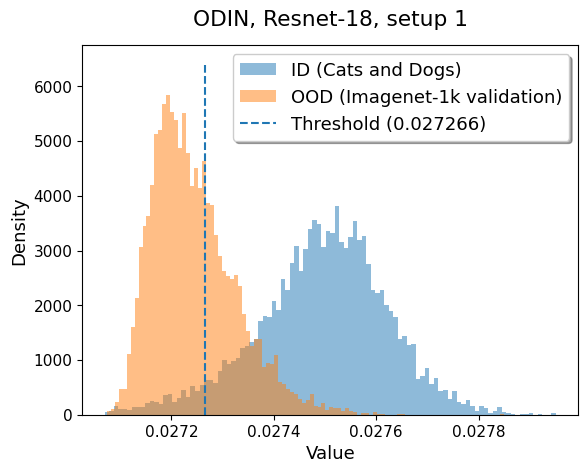

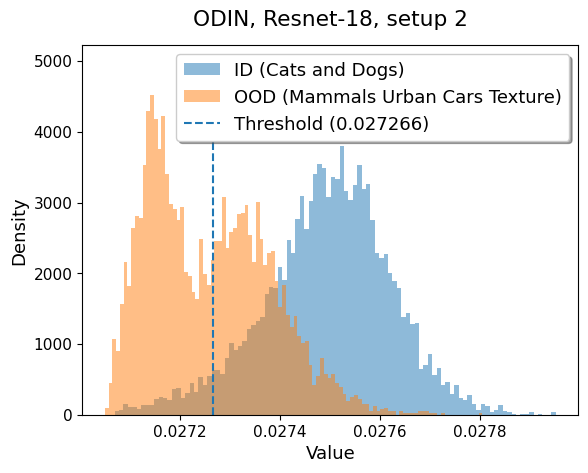

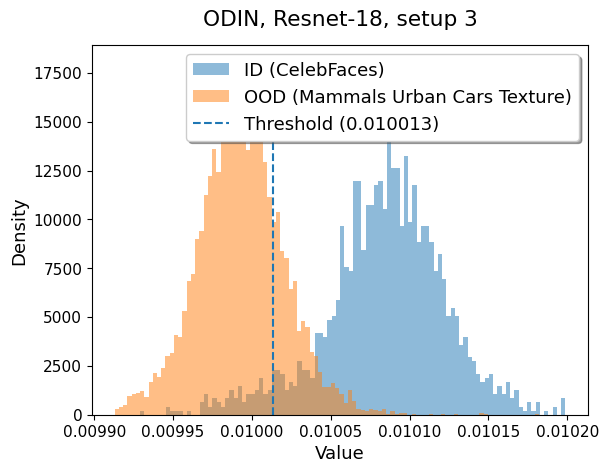

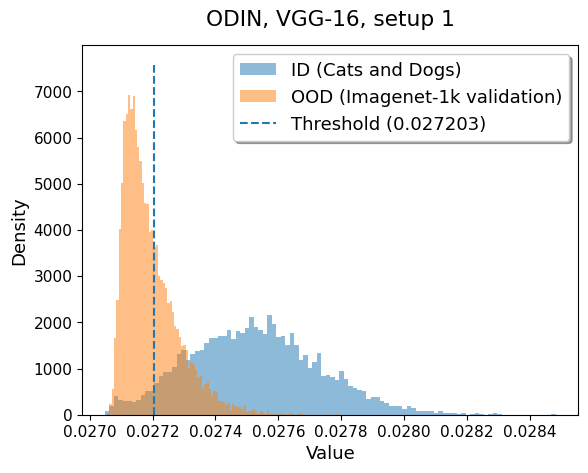

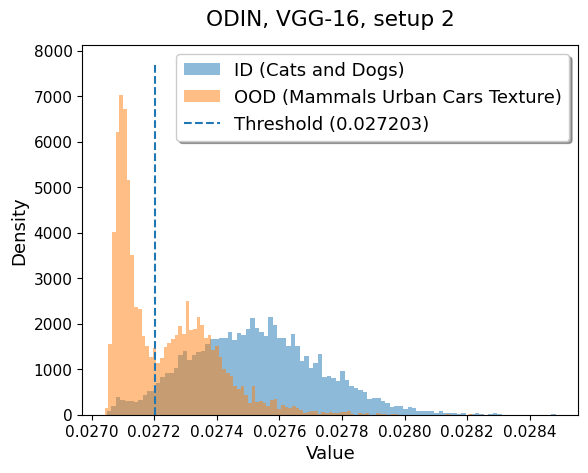

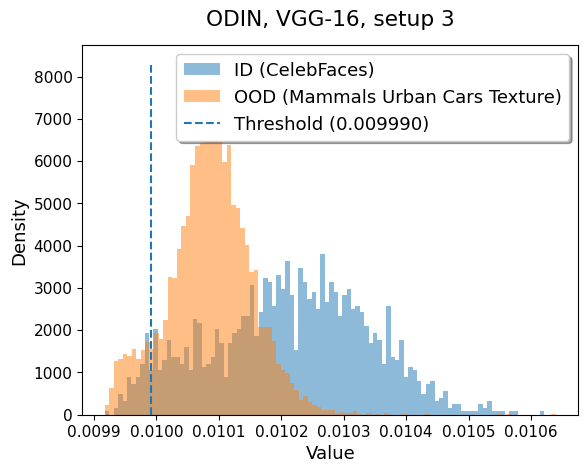

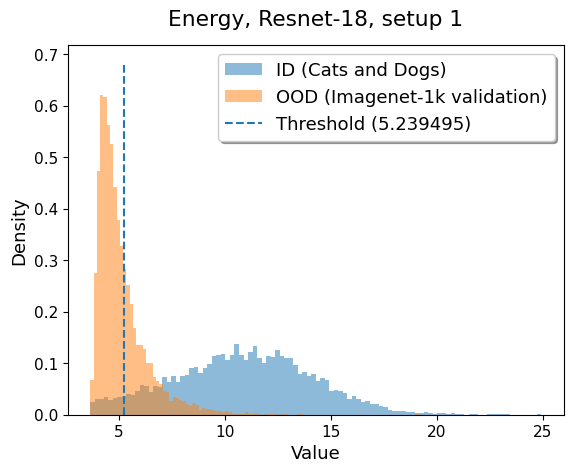

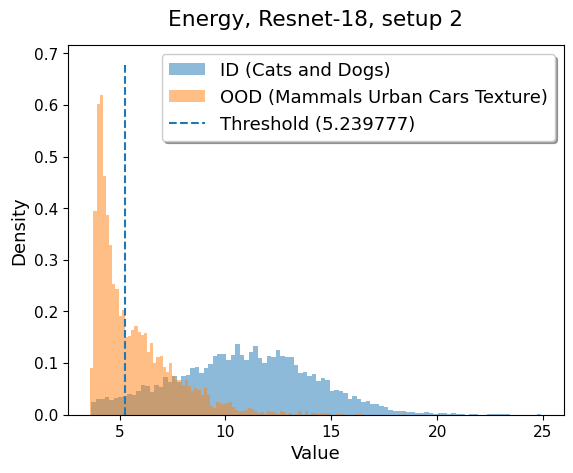

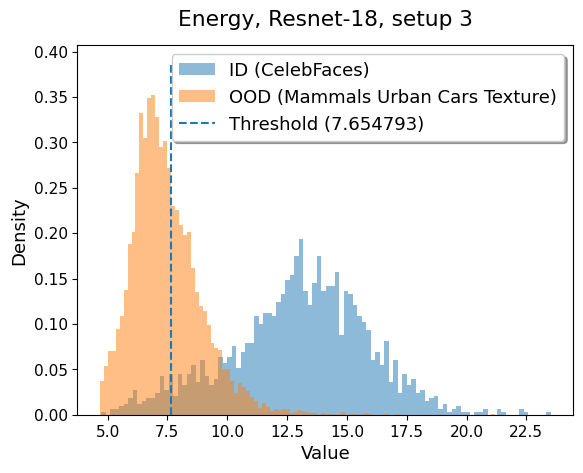

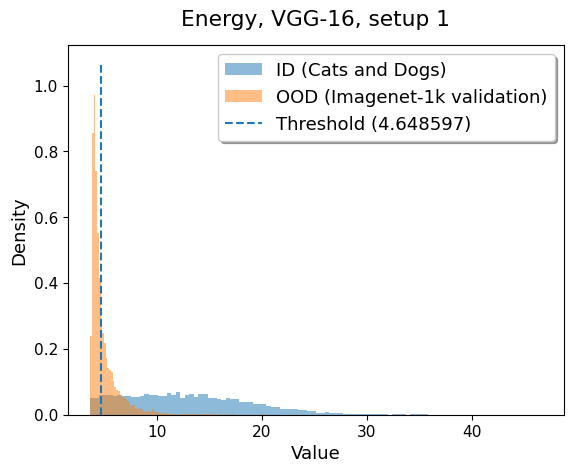

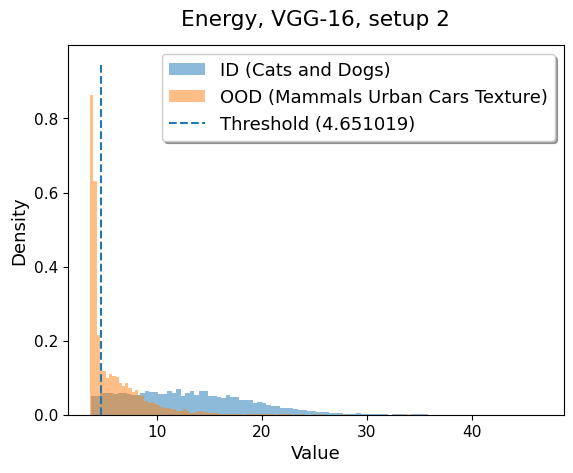

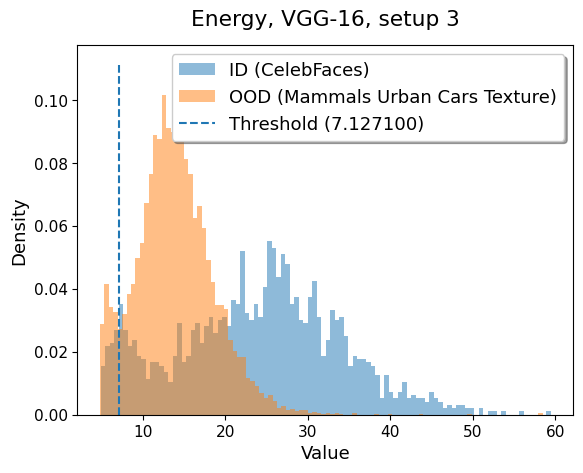

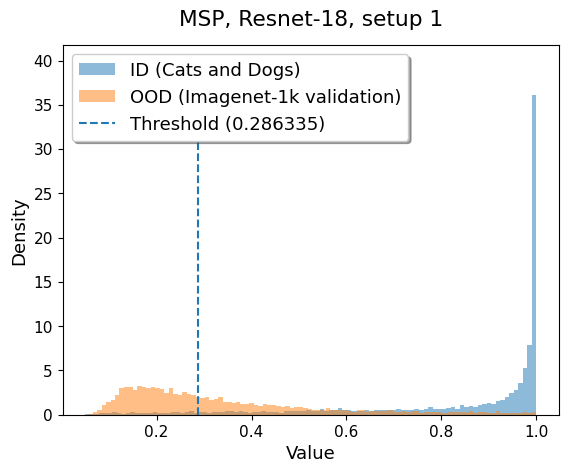

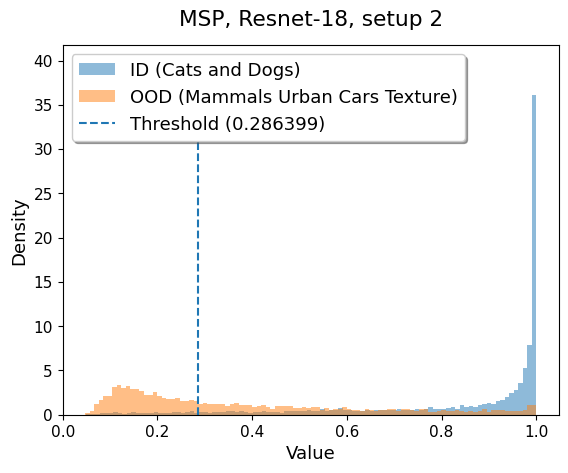

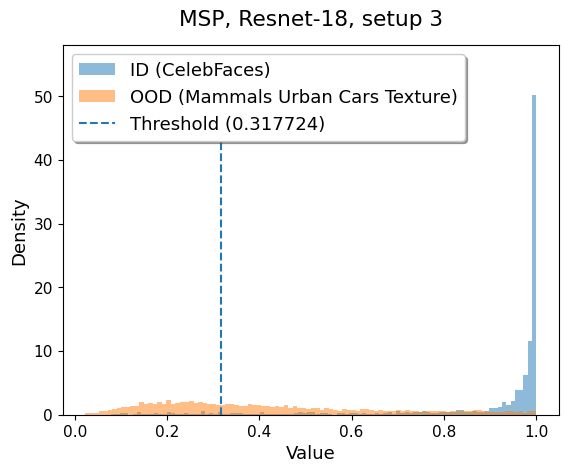

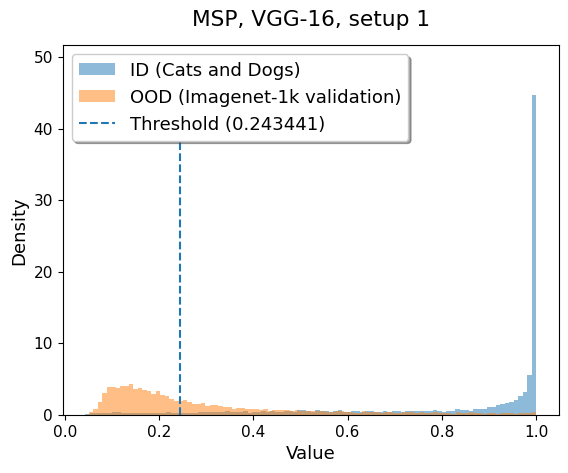

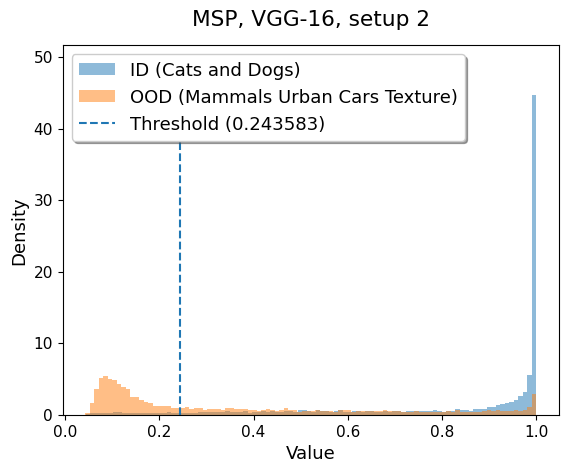

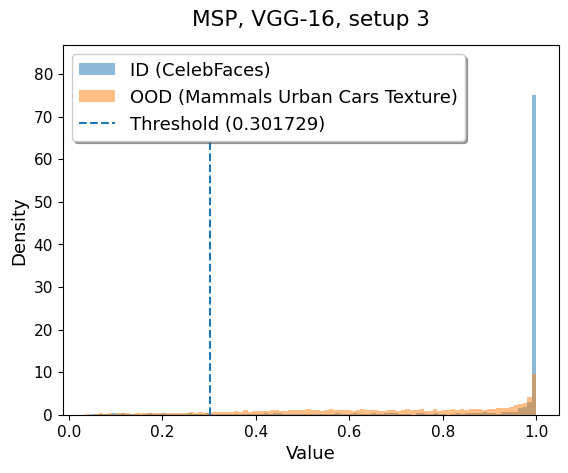

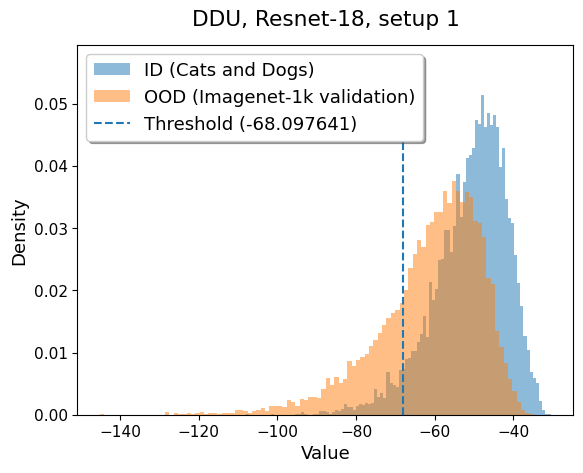

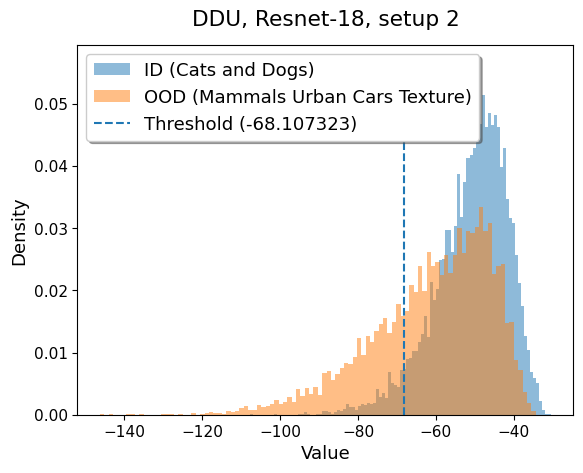

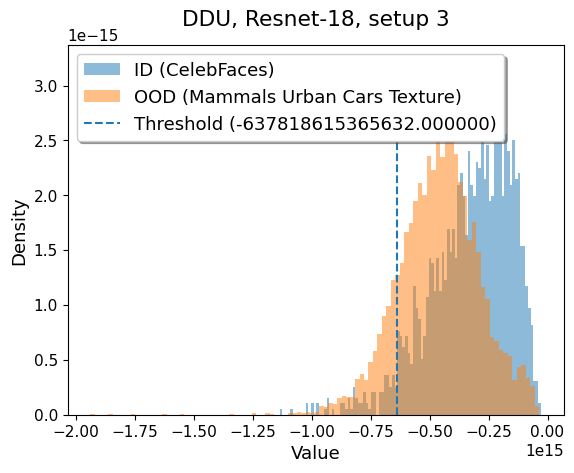

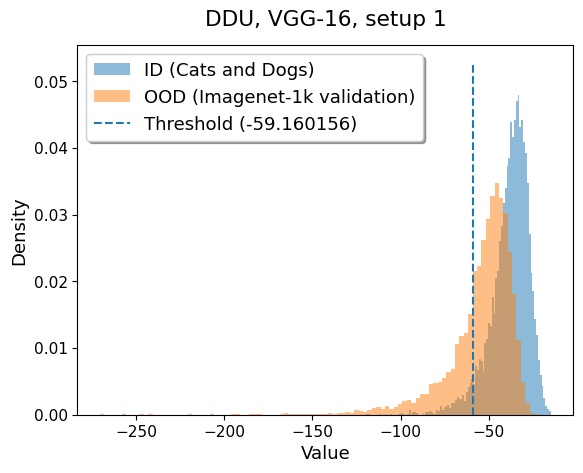

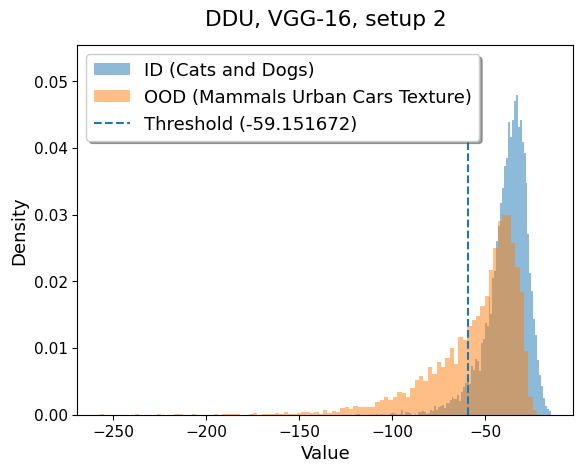

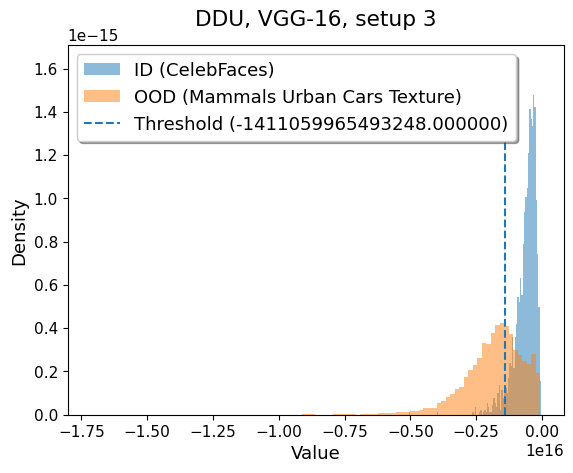

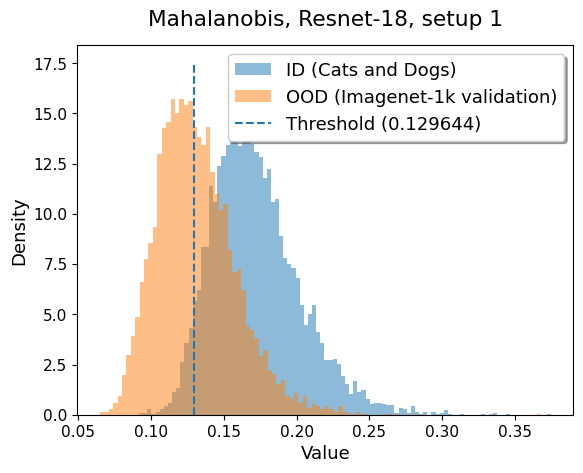

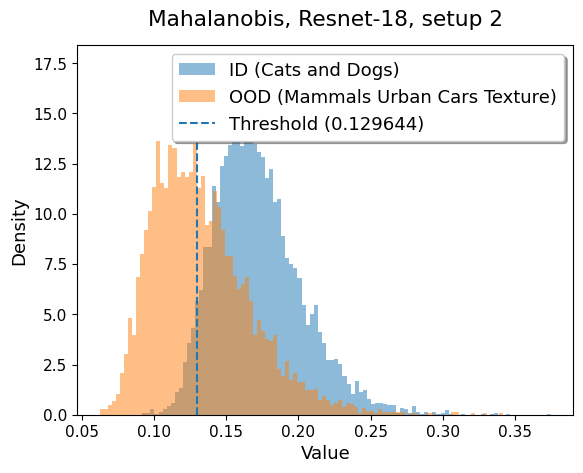

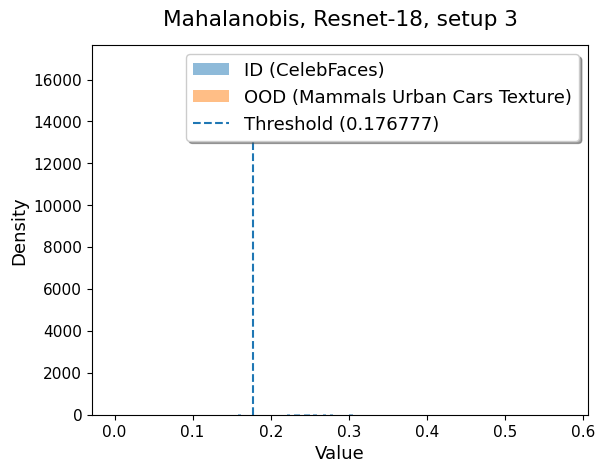

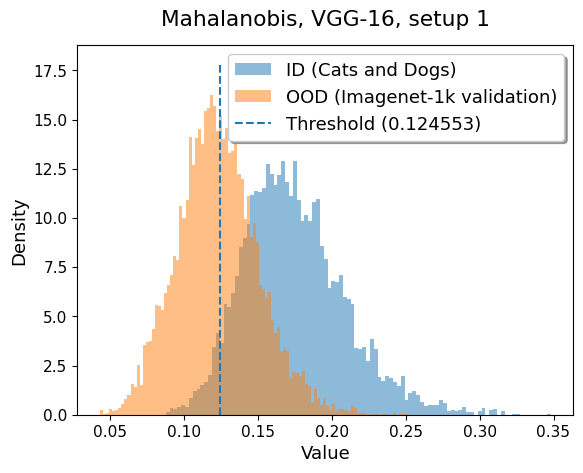

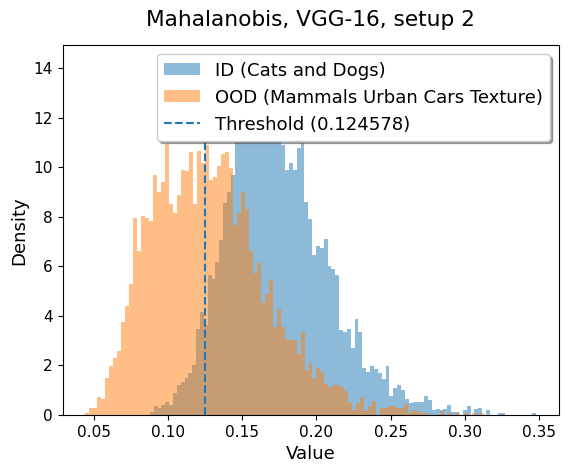

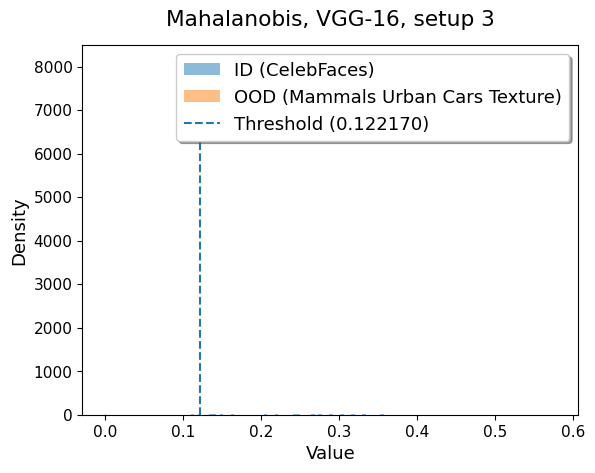

In [35]:
import matplotlib

# ODIN
visualizeThreshold(turmoil(odin_s12_res_in_examples), turmoil(odin_s1_res_out_examples), res_s1_odin_threshold, "ODIN, Resnet-18, setup 1", extra_plot=False)
visualizeThreshold(turmoil(odin_s12_res_in_examples), turmoil(odin_s2_res_out_examples), res_s2_odin_threshold, "ODIN, Resnet-18, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(odin_s3_res_in_examples), turmoil(odin_s3_res_out_examples), res_s3_odin_threshold, "ODIN, Resnet-18, setup 3", l1='ID (CelebFaces)', l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(odin_s12_vgg_in_examples), turmoil(odin_s1_vgg_out_examples), vgg_s1_odin_threshold, "ODIN, VGG-16, setup 1", extra_plot=False)
visualizeThreshold(turmoil(odin_s12_vgg_in_examples), turmoil(odin_s2_vgg_out_examples), vgg_s2_odin_threshold, "ODIN, VGG-16, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(odin_s3_vgg_in_examples), turmoil(odin_s3_vgg_out_examples), vgg_s3_odin_threshold, "ODIN, VGG-16, setup 3", l1='ID (CelebFaces)', l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# Energy
visualizeThreshold(turmoil(energy_s12_res_in_examples), turmoil(energy_s1_res_out_examples), res_s1_energy_threshold, "Energy, Resnet-18, setup 1", extra_plot=False)
visualizeThreshold(turmoil(energy_s12_res_in_examples), turmoil(energy_s2_res_out_examples), res_s2_energy_threshold, "Energy, Resnet-18, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(energy_s3_res_in_examples), turmoil(energy_s3_res_out_examples), res_s3_energy_threshold, "Energy, Resnet-18, setup 3", l1='ID (CelebFaces)', l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(energy_s12_vgg_in_examples), turmoil(energy_s1_vgg_out_examples), vgg_s1_energy_threshold, "Energy, VGG-16, setup 1", extra_plot=False)
visualizeThreshold(turmoil(energy_s12_vgg_in_examples), turmoil(energy_s2_vgg_out_examples), vgg_s2_energy_threshold, "Energy, VGG-16, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(energy_s3_vgg_in_examples), turmoil(energy_s3_vgg_out_examples), vgg_s3_energy_threshold, "Energy, VGG-16, setup 3", l1='ID (CelebFaces)', l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# MSP
visualizeThreshold(turmoil(msp_s12_res_in_examples), turmoil(msp_s1_res_out_examples), res_s1_msp_threshold, "MSP, Resnet-18, setup 1", extra_plot=False)
visualizeThreshold(turmoil(msp_s12_res_in_examples), turmoil(msp_s2_res_out_examples), res_s2_msp_threshold, "MSP, Resnet-18, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(msp_s3_res_in_examples), turmoil(msp_s3_res_out_examples), res_s3_msp_threshold, "MSP, Resnet-18, setup 3", l1='ID (CelebFaces)', l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(msp_s12_vgg_in_examples), turmoil(msp_s1_vgg_out_examples), vgg_s1_msp_threshold, "MSP, VGG-16, setup 1", extra_plot=False)
visualizeThreshold(turmoil(msp_s12_vgg_in_examples), turmoil(msp_s2_vgg_out_examples), vgg_s2_msp_threshold, "MSP, VGG-16, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(msp_s3_vgg_in_examples), turmoil(msp_s3_vgg_out_examples), vgg_s3_msp_threshold, "MSP, VGG-16, setup 3", l1='ID (CelebFaces)', l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# DDU
visualizeThreshold(turmoil(s12_res_ddu_in_scores), turmoil(s1_res_ddu_out_scores), res_s1_ddu_threshold, "DDU, Resnet-18, setup 1", extra_plot=False)
visualizeThreshold(turmoil(s12_res_ddu_in_scores), turmoil(s2_res_ddu_out_scores), res_s2_ddu_threshold, "DDU, Resnet-18, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s3_res_ddu_in_scores), turmoil(s3_res_ddu_out_scores), res_s3_ddu_threshold, "DDU, Resnet-18, setup 3", l1='ID (CelebFaces)', l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s12_vgg_ddu_in_scores), turmoil(s1_vgg_ddu_out_scores), vgg_s1_ddu_threshold, "DDU, VGG-16, setup 1", extra_plot=False)
visualizeThreshold(turmoil(s12_vgg_ddu_in_scores), turmoil(s2_vgg_ddu_out_scores), vgg_s2_ddu_threshold, "DDU, VGG-16, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil(s3_vgg_ddu_in_scores), turmoil(s3_vgg_ddu_out_scores), vgg_s3_ddu_threshold, "DDU, VGG-16, setup 3", l1='ID (CelebFaces)', l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

# Mahalanobis
visualizeThreshold(turmoil_switch(res_cd_mahalanobis_distances), turmoil_switch(res_s1ood_mahalanobis_distances), res_s1_mahalanobis_threshold, "Mahalanobis, Resnet-18, setup 1", extra_plot=False)
visualizeThreshold(turmoil_switch(res_cd_mahalanobis_distances), turmoil_switch(res_s2ood_mahalanobis_distances), res_s2_mahalanobis_threshold, "Mahalanobis, Resnet-18, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil_switch(res_cf_mahalanobis_distances), turmoil_switch(res_s3ood_mahalanobis_distances), res_s3_mahalanobis_threshold, "Mahalanobis, Resnet-18, setup 3", l1='ID (CelebFaces)', l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil_switch(vgg_cd_mahalanobis_distances), turmoil_switch(vgg_s1ood_mahalanobis_distances), vgg_s1_mahalanobis_threshold, "Mahalanobis, VGG-16, setup 1", extra_plot=False)
visualizeThreshold(turmoil_switch(vgg_cd_mahalanobis_distances), turmoil_switch(vgg_s2ood_mahalanobis_distances), vgg_s2_mahalanobis_threshold, "Mahalanobis, VGG-16, setup 2", l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)
visualizeThreshold(turmoil_switch(vgg_cf_mahalanobis_distances), turmoil_switch(vgg_s3ood_mahalanobis_distances), vgg_s3_mahalanobis_threshold, "Mahalanobis, VGG-16, setup 3", l1='ID (CelebFaces)', l2='OOD (Mammals Urban Cars Texture)', extra_plot=False)

In [37]:
print("ODIN")
print(round(res_s1_odin_auroc, 4), round(res_s1_odin_aupr_in, 4), round(res_s1_odin_aupr_out, 4), round(res_s1_odin_fpr95, 4), round(res_s1_odin_threshold, 4))
print(round(vgg_s1_odin_auroc, 4), round(vgg_s1_odin_aupr_in, 4), round(vgg_s1_odin_aupr_out, 4), round(vgg_s1_odin_fpr95, 4), round(vgg_s1_odin_threshold, 4))
print(round(res_s2_odin_auroc, 4), round(res_s2_odin_aupr_in, 4), round(res_s2_odin_aupr_out, 4), round(res_s2_odin_fpr95, 4), round(res_s2_odin_threshold, 4))
print(round(vgg_s2_odin_auroc, 4), round(vgg_s2_odin_aupr_in, 4), round(vgg_s2_odin_aupr_out, 4), round(vgg_s2_odin_fpr95, 4), round(vgg_s2_odin_threshold, 4))
print(round(res_s3_odin_auroc, 4), round(res_s3_odin_aupr_in, 4), round(res_s3_odin_aupr_out, 4), round(res_s3_odin_fpr95, 4), round(res_s3_odin_threshold, 4))
print(round(vgg_s3_odin_auroc, 4), round(vgg_s3_odin_aupr_in, 4), round(vgg_s3_odin_aupr_out, 4), round(vgg_s3_odin_fpr95, 4), round(vgg_s3_odin_threshold, 4))
print("")
print("Energy")
print(round(res_s1_energy_auroc, 4), round(res_s1_energy_aupr_in, 4), round(res_s1_energy_aupr_out, 4), round(res_s1_energy_fpr95, 4), round(res_s1_energy_threshold, 4))
print(round(vgg_s1_energy_auroc, 4), round(vgg_s1_energy_aupr_in, 4), round(vgg_s1_energy_aupr_out, 4), round(vgg_s1_energy_fpr95, 4), round(vgg_s1_energy_threshold, 4))
print(round(res_s2_energy_auroc, 4), round(res_s2_energy_aupr_in, 4), round(res_s2_energy_aupr_out, 4), round(res_s2_energy_fpr95, 4), round(res_s2_energy_threshold, 4))
print(round(vgg_s2_energy_auroc, 4), round(vgg_s2_energy_aupr_in, 4), round(vgg_s2_energy_aupr_out, 4), round(vgg_s2_energy_fpr95, 4), round(vgg_s2_energy_threshold, 4))
print(round(res_s3_energy_auroc, 4), round(res_s3_energy_aupr_in, 4), round(res_s3_energy_aupr_out, 4), round(res_s3_energy_fpr95, 4), round(res_s3_energy_threshold, 4))
print(round(vgg_s3_energy_auroc, 4), round(vgg_s3_energy_aupr_in, 4), round(vgg_s3_energy_aupr_out, 4), round(vgg_s3_energy_fpr95, 4), round(vgg_s3_energy_threshold, 4))
print("")
print("MSP")
print(round(res_s1_msp_auroc, 4), round(res_s1_msp_aupr_in, 4), round(res_s1_msp_aupr_out, 4), round(res_s1_msp_fpr95, 4), round(res_s1_msp_threshold, 4))
print(round(vgg_s1_msp_auroc, 4), round(vgg_s1_msp_aupr_in, 4), round(vgg_s1_msp_aupr_out, 4), round(vgg_s1_msp_fpr95, 4), round(vgg_s1_msp_threshold, 4))
print(round(res_s2_msp_auroc, 4), round(res_s2_msp_aupr_in, 4), round(res_s2_msp_aupr_out, 4), round(res_s2_msp_fpr95, 4), round(res_s2_msp_threshold, 4))
print(round(vgg_s2_msp_auroc, 4), round(vgg_s2_msp_aupr_in, 4), round(vgg_s2_msp_aupr_out, 4), round(vgg_s2_msp_fpr95, 4), round(vgg_s2_msp_threshold, 4))
print(round(res_s3_msp_auroc, 4), round(res_s3_msp_aupr_in, 4), round(res_s3_msp_aupr_out, 4), round(res_s3_msp_fpr95, 4), round(res_s3_msp_threshold, 4))
print(round(vgg_s3_msp_auroc, 4), round(vgg_s3_msp_aupr_in, 4), round(vgg_s3_msp_aupr_out, 4), round(vgg_s3_msp_fpr95, 4), round(vgg_s3_msp_threshold, 4))
print("")
print("DDU")
print(round(res_s1_ddu_auroc, 4), round(res_s1_ddu_aupr_in, 4), round(res_s1_ddu_aupr_out, 4), round(res_s1_ddu_fpr95, 4), round(res_s1_ddu_threshold, 4))
print(round(vgg_s1_ddu_auroc, 4), round(vgg_s1_ddu_aupr_in, 4), round(vgg_s1_ddu_aupr_out, 4), round(vgg_s1_ddu_fpr95, 4), round(vgg_s1_ddu_threshold, 4))
print(round(res_s2_ddu_auroc, 4), round(res_s2_ddu_aupr_in, 4), round(res_s2_ddu_aupr_out, 4), round(res_s2_ddu_fpr95, 4), round(res_s2_ddu_threshold, 4))
print(round(vgg_s2_ddu_auroc, 4), round(vgg_s2_ddu_aupr_in, 4), round(vgg_s2_ddu_aupr_out, 4), round(vgg_s2_ddu_fpr95, 4), round(vgg_s2_ddu_threshold, 4))
print(round(res_s3_ddu_auroc, 4), round(res_s3_ddu_aupr_in, 4), round(res_s3_ddu_aupr_out, 4), round(res_s3_ddu_fpr95, 4), round(res_s3_ddu_threshold, 4))
print(round(vgg_s3_ddu_auroc, 4), round(vgg_s3_ddu_aupr_in, 4), round(vgg_s3_ddu_aupr_out, 4), round(vgg_s3_ddu_fpr95, 4), round(vgg_s3_ddu_threshold, 4))
print("")
print("Mahalanobis")
print(round(res_s1_mahalanobis_auroc, 4), round(res_s1_mahalanobis_aupr_in, 4), round(res_s1_mahalanobis_aupr_out, 4), round(res_s1_mahalanobis_fpr95, 4), round(res_s1_mahalanobis_threshold, 4))
print(round(vgg_s1_mahalanobis_auroc, 4), round(vgg_s1_mahalanobis_aupr_in, 4), round(vgg_s1_mahalanobis_aupr_out, 4), round(vgg_s1_mahalanobis_fpr95, 4), round(vgg_s1_mahalanobis_threshold, 4))
print(round(res_s2_mahalanobis_auroc, 4), round(res_s2_mahalanobis_aupr_in, 4), round(res_s2_mahalanobis_aupr_out, 4), round(res_s2_mahalanobis_fpr95, 4), round(res_s2_mahalanobis_threshold, 4))
print(round(vgg_s2_mahalanobis_auroc, 4), round(vgg_s2_mahalanobis_aupr_in, 4), round(vgg_s2_mahalanobis_aupr_out, 4), round(vgg_s2_mahalanobis_fpr95, 4), round(vgg_s2_mahalanobis_threshold, 4))
print(round(res_s3_mahalanobis_auroc, 4), round(res_s3_mahalanobis_aupr_in, 4), round(res_s3_mahalanobis_aupr_out, 4), round(res_s3_mahalanobis_fpr95, 4), round(res_s3_mahalanobis_threshold, 4))
print(round(vgg_s3_mahalanobis_auroc, 4), round(vgg_s3_mahalanobis_aupr_in, 4), round(vgg_s3_mahalanobis_aupr_out, 4), round(vgg_s3_mahalanobis_fpr95, 4), round(vgg_s3_mahalanobis_threshold, 4))


ODIN
0.941 0.9391 0.9262 0.3379 0.0273
0.9337 0.9343 0.9121 0.3583 0.0272
0.9046 0.9208 0.8736 0.4666 0.0273
0.8721 0.889 0.838 0.4774 0.0272
0.9631 0.9146 0.9878 0.2168 0.01
0.7961 0.6769 0.9171 0.9097 0.01

Energy
0.9467 0.9493 0.9268 0.3281 5.2395
0.9342 0.9362 0.918 0.3791 4.6486
0.9159 0.9343 0.8703 0.4399 5.2398
0.8841 0.9034 0.8496 0.4664 4.651
0.9453 0.8806 0.9808 0.3781 7.6548
0.8063 0.691 0.9166 0.9202 7.1271

MSP
0.9163 0.915 0.8998 0.4733 0.2863
0.9187 0.9173 0.9051 0.428 0.2434
0.8905 0.9151 0.8393 0.5072 0.2864
0.8785 0.8958 0.8409 0.4761 0.2436
0.9204 0.835 0.9725 0.5753 0.3177
0.8479 0.7566 0.9329 0.9041 0.3017

DDU
0.7467 0.7022 0.7859 0.755 -68.0976
0.8169 0.801 0.8332 0.7216 -59.1602
0.7068 0.7204 0.6963 0.7118 -68.1073
0.7558 0.784 0.7362 0.6764 -59.1517
0.725 0.3639 0.9051 0.8565 -637818600000000.0
0.8622 0.4642 0.9684 0.3862 -1411060000000000.0

Mahalanobis
0.8562 0.7947 0.896 0.4729 0.1296
0.8887 0.8591 0.9126 0.4562 0.1246
0.8184 0.7945 0.8318 0.477 0.1296
0.825

In [26]:
print("{:e}".format(-637818600000000.0))
print("{:e}".format(-1411060000000000.0))

-6.378186e+14
-1.411060e+15


In [41]:
print(res_s3_mahalanobis_auroc, res_s3_mahalanobis_aupr_in, res_s3_mahalanobis_aupr_out, res_s3_mahalanobis_fpr95, res_s3_mahalanobis_threshold)
print(vgg_s3_mahalanobis_auroc, vgg_s3_mahalanobis_aupr_in, vgg_s3_mahalanobis_aupr_out, vgg_s3_mahalanobis_fpr95, vgg_s3_mahalanobis_threshold)


1.0 1.0 1.0 0.0 0.1767767464454411
1.0 1.0 1.0 0.0 0.12216957368193232
